Weak Fe I lines for 11/08/2021 night.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import dfitspy
import os
import glob
from matplotlib.colors import Normalize
from scipy.sparse import lil_matrix
from scipy.stats import spearmanr
import iCCF
import tqdm

from ldtk import LDPSetCreator, BoxcarFilter
import SOAP # type: ignore

/home/telmo/.local/lib/python3.10/site-packages/iCCF/chromatic.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream
/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#### Folder where the images are located
directory_path = 'Eduardos_code/telluric_corrected_spectra/'
listfiles=glob.glob(os.path.join(directory_path, '*.fits'))

listkeys=['DATE-OBS','HIERARCH ESO QC BJD']
fitsort = dfitspy.dfitsort(listfiles, listkeys,exact=True)
dfitspy.dfitsort_view(fitsort)

                      filename                      	       DATE-OBS        	HIERARCH ESO QC BJD
----------------------------------------------------	-----------------------	-------------------
corr.ESPRE.2021-08-11T03_39_22.784_S1D_SKYSUB_A.fits	2021-08-11T03:39:22.784	 2459437.65918491  
corr.ESPRE.2021-08-11T04_09_20.370_S1D_SKYSUB_A.fits	2021-08-11T04:09:20.370	 2459437.67990556  
corr.ESPRE.2021-08-31T00_45_49.880_S1D_SKYSUB_A.fits	2021-08-31T00:45:49.879	 2459457.53808774  
corr.ESPRE.2021-08-31T03_52_05.909_S1D_SKYSUB_A.fits	2021-08-31T03:52:05.908	 2459457.66749064  
corr.ESPRE.2021-08-11T04_03_20.918_S1D_SKYSUB_A.fits	2021-08-11T04:03:20.918	 2459437.67588783  
corr.ESPRE.2021-08-11T03_57_21.598_S1D_SKYSUB_A.fits	2021-08-11T03:57:21.597	 2459437.67166382  
corr.ESPRE.2021-08-11T04_21_22.562_S1D_SKYSUB_A.fits	2021-08-11T04:21:22.561	 2459437.68835265  
corr.ESPRE.2021-08-11T03_27_23.534_S1D_SKYSUB_A.fits	2021-08-11T03:27:23.533	 2459437.65084057  
corr.ESPRE.2021-08-31T03_40_04

In [3]:
#List files names in order
list_spectra = []
for name in listfiles:
    if '2021-08-11' in name and 'SKY' in name:
        list_spectra.append(name)
print(len(list_spectra),list_spectra)

list_spectra = sorted(list_spectra)

#removing low SNR observation
list_spectra = list_spectra[:-1]

print(len(list_spectra),list_spectra)

41 ['Eduardos_code/telluric_corrected_spectra/corr.ESPRE.2021-08-11T03_39_22.784_S1D_SKYSUB_A.fits', 'Eduardos_code/telluric_corrected_spectra/corr.ESPRE.2021-08-11T04_09_20.370_S1D_SKYSUB_A.fits', 'Eduardos_code/telluric_corrected_spectra/corr.ESPRE.2021-08-11T04_03_20.918_S1D_SKYSUB_A.fits', 'Eduardos_code/telluric_corrected_spectra/corr.ESPRE.2021-08-11T03_57_21.598_S1D_SKYSUB_A.fits', 'Eduardos_code/telluric_corrected_spectra/corr.ESPRE.2021-08-11T04_21_22.562_S1D_SKYSUB_A.fits', 'Eduardos_code/telluric_corrected_spectra/corr.ESPRE.2021-08-11T03_27_23.534_S1D_SKYSUB_A.fits', 'Eduardos_code/telluric_corrected_spectra/corr.ESPRE.2021-08-11T01_33_17.472_S1D_SKYSUB_A.fits', 'Eduardos_code/telluric_corrected_spectra/corr.ESPRE.2021-08-11T02_57_20.533_S1D_SKYSUB_A.fits', 'Eduardos_code/telluric_corrected_spectra/corr.ESPRE.2021-08-11T02_45_18.607_S1D_SKYSUB_A.fits', 'Eduardos_code/telluric_corrected_spectra/corr.ESPRE.2021-08-11T02_27_17.370_S1D_SKYSUB_A.fits', 'Eduardos_code/telluric_co

In [4]:
file_test = directory_path+'corr.ESPRE.2021-08-11T03_39_22.784_S1D_SKYSUB_A.fits'

hdutest = fits.open(file_test)
hdutest.info()
hdutest.close()

Filename: Eduardos_code/telluric_corrected_spectra/corr.ESPRE.2021-08-11T03_39_22.784_S1D_SKYSUB_A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    2027   ()      
  1                1 BinTableHDU     24   443262R x 5C   [1D, 1D, 1D, 1D, 1J]   
  2  BEST_FIT_PARAMETERS    1 BinTableHDU    125   42R x 3C   [23A, 1D, 1D]   
  3  TELLURIC_DATA    1 BinTableHDU     34   443262R x 10C   [1J, 1D, 1D, 1D, 1D, 1D, 1D, 1D, 1J, 1D]   


In [5]:
#checking the header
f = fits.getdata(file_test,1)
f1 = fits.getdata(file_test,2)
fh = fits.getheader(file_test)
fh #HIERARCH ESO OBS START

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                    8 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2024-01-31T22:58:32' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
TELESCOP= 'ESO-VLT-U1'         / ESO <TEL>                                      
INSTRUME= 'ESPRESSO'           / Instrument used.                               
OBJECT  = 'HD 189733'          / Original target.                               
RA      =           300.182485 / [deg] 20:00:43.7 RA (J2000) pointing           
DEC     =             22.709

In [6]:
hdul = fits.open(file_test)

tbl = hdul[1].data   
wavelength = np.array(tbl.field(1))
flux = np.array(tbl.field(2))
flux_error = np.array(tbl.field(3))
quality = np.array(tbl.field(4))

berv = hdul[0].header['HIERARCH ESO QC BERV']

hdul.close()

## Make CCFs

In [8]:
from bisect import bisect_left

#adapted from iCCF.meta.espdr_compute_CCF_fast
def compute_CCF(ll, dll, flux, error, quality, RV_table, mask, berv, bervmax, mask_width=0.5):
    c = 299792.458
    nx_s2d = flux.size
    n_mask = mask["lambda"].size
    nx_ccf = len(RV_table)

    ccf_flux = np.zeros_like(RV_table)
    ccf_error = np.zeros_like(RV_table)
    ccf_quality = np.zeros_like(RV_table)

    ll2 = ll - dll / 2.0 

    imin, imax = 1, nx_s2d
    while(imin < nx_s2d and quality[imin-1] != 0):
        imin += 1
    while(imax > 1 and quality[imax-1] != 0):
        imax -= 1

    if imin >= imax:
        return
  
    llmin = ll[imin + 1 - 1] / (1. + berv / c) * (1. + bervmax / c) / (1. + RV_table[0] / c)
    llmax = ll[imax - 1 - 1] / (1. + berv / c) * (1. - bervmax / c) / (1. + RV_table[nx_ccf - 1] / c)

    imin, imax = 0, n_mask - 1

    while (imin < n_mask and mask['lambda'][imin] < (llmin + 0.5 * mask_width / c * llmin)):
        imin += 1
    while (imax >= 0     and mask['lambda'][imax] > (llmax - 0.5 * mask_width / c * llmax)):
        imax -= 1

    for i in range(imin, imax + 1):

        llcenter = mask['lambda'][i] * (1. + RV_table[nx_ccf // 2] / c)
        contrast = mask['contrast'][i]
        w = contrast * contrast

        for j in range(0, nx_ccf):
            llcenter = mask['lambda'][i] * (1. + RV_table[j] / c)
            llstart = llcenter - 0.5 * mask_width / c * llcenter
            llstop = llcenter + 0.5 * mask_width / c * llcenter

            index1 = bisect_left(ll2, llstart) + 1
            index2 = bisect_left(ll2, llcenter) + 1
            index3 = bisect_left(ll2, llstop) + 1

            k = j
            for index in range(index1, index3):
                ccf_flux[k] += w * flux[index-1]

            ccf_flux[k] += w * flux[index1-1-1] * (ll2[index1-1]-llstart) / dll[index1-1-1] 
            ccf_flux[k] -= w * flux[index3-1-1] * (ll2[index3-1]-llstop) / dll[index3-1-1] 

            ccf_error[k] += w * w * error[index2 - 1 - 1] * error[index2 - 1 - 1]
            ccf_quality[k] += quality[index2 - 1 - 1]

    ccf_error = np.sqrt(ccf_error)

    return ccf_flux, ccf_error, ccf_quality

In [9]:
line_list_weak_iron = np.array([4551.6499, 5539.2824, 6165.3641,
4593.5268, 5552.6919, 6226.7403, 4657.5879, 5568.8689, 6311.5050,
4658.2976, 5607.6668, 6315.8164, 4672.8364, 5611.3587, 6380.7483,
4726.1396, 5618.6360, 6385.7206, 4785.9583, 5635.8247, 6392.5429,
4794.3571, 5636.6992, 6436.4102, 4799.4092, 5646.6854, 6496.4738,
4802.5216, 5651.4716, 6574.2325, 4808.1509, 5652.3194, 6581.2143,
4809.9400, 5661.3480, 6608.0301, 5213.8071, 5677.6875, 6627.5488,
5223.1851, 5680.2441, 6646.9355, 5236.2039, 5720.8950, 6703.5720,
5293.9609, 5793.9178, 6710.3213, 5294.5493, 5807.7868, 6737.9830,
5358.1168, 5811.9172, 6739.5243, 5386.3345, 5814.8092, 6745.9626,
5395.2187, 5827.8794, 6746.9508, 5417.0405, 5835.1018, 6752.7107,
5460.8762, 5852.2222, 6793.2656, 5461.5530, 5858.7840, 6806.8491,
5464.2825, 5861.1123, 6820.3730, 5470.0957, 5881.2822, 6828.5976,
5487.1489, 5902.4755, 6839.8340, 5491.8346, 5929.6802, 6841.3450,
5493.5012, 6034.0365, 6843.6606, 5522.4491, 6082.7147])

mask = {"lambda":line_list_weak_iron, 
        "contrast":np.zeros_like(line_list_weak_iron)+1}

In [10]:
RV_table = np.arange(-22,18.5,0.5)

dll = np.gradient(wavelength)

In [11]:
ccf = iCCF.meta.espdr_compute_CCF_fast(ll = wavelength,
                                dll = dll,
                                flux = flux,
                                error = flux_error,
                                blaze = np.ones_like(flux),
                                quality = quality,
                                RV_table = RV_table,
                                mask = mask,
                                berv = berv,
                                bervmax = np.max(np.abs(RV_table)),
                                mask_width = 0.5)

ccf

(array([6342026.97157444, 6339609.67633126, 6340872.77629347,
        6341399.6948648 , 6346363.22136591, 6352215.58363567,
        6354516.71482859, 6362823.36584291, 6365484.25968384,
        6368715.02902115, 6373746.61156068, 6378387.59756724,
        6383241.71827025, 6387956.49427666, 6387945.21484611,
        6388257.98396059, 6389335.87337434, 6394164.70630159,
        6395646.73674744, 6390454.86424952, 6390854.53589338,
        6393109.32943382, 6391013.5839667 , 6383018.45242596,
        6373223.6639683 , 6358604.42234672, 6335306.6853633 ,
        6298452.10246771, 6243567.288837  , 6173411.2989711 ,
        6083185.66630864, 5961876.63482349, 5815600.01510323,
        5637429.41964395, 5451005.8376791 , 5259705.24351694,
        5074745.01310101, 4918811.73132072, 4799831.39451891,
        4729963.7110328 , 4725654.62082207, 4781410.13588654,
        4893631.55470111, 5049924.87272455, 5231376.34805964,
        5423929.26487894, 5617755.17199669, 5789037.0451079 ,
        

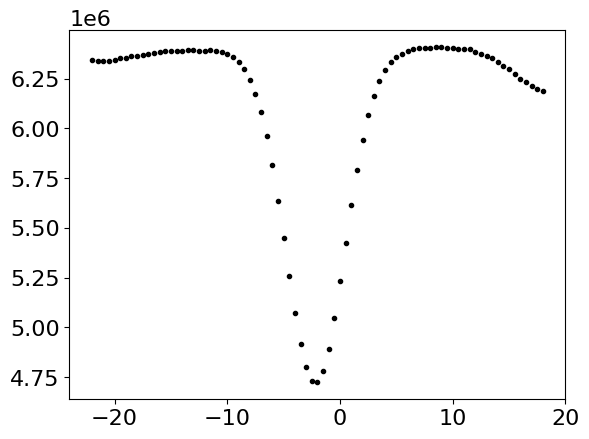

In [12]:
plt.figure()
plt.errorbar(x=RV_table, y=ccf[0], yerr=ccf[1], fmt="k.")
plt.show()

In [12]:
CCFs_strong_iron = np.zeros((len(list_spectra), 2, RV_table.shape[0]))

N = 1000 #number of samples

for i in tqdm.tqdm(range(len(list_spectra))):

    hdul = fits.open(file_test)
    tbl = hdul[1].data   
    wavelength = np.array(tbl.field(1))
    flux = np.array(tbl.field(2))
    flux_error = np.array(tbl.field(3))
    quality = np.array(tbl.field(4))
    berv = hdul[0].header['HIERARCH ESO QC BERV']
    hdul.close()

    ccf = iCCF.meta.espdr_compute_CCF_fast(ll = wavelength,
                                dll = np.gradient(wavelength),
                                flux = flux,
                                error = flux_error,
                                blaze = np.ones_like(flux),
                                quality = quality,
                                RV_table = RV_table,
                                mask = mask,
                                berv = berv,
                                bervmax = np.max(np.abs(RV_table)),
                                mask_width = 0.5)
    
    CCFs_strong_iron[i,0] = ccf[0]

    M = len(flux)
    samples = np.zeros([M,N])
    for j in range(M):
        ymean = flux[j]
        ysigma = flux_error[j]
        samples[j,:] = np.random.normal(ymean, ysigma, N)

    jitter = np.zeros((RV_table.shape[0],N))

    for k in range(N):
        ccf_jitter = iCCF.meta.espdr_compute_CCF_fast(ll = wavelength,
                                dll = np.gradient(wavelength),
                                flux = samples[:,k],
                                error = np.zeros_like(flux),
                                blaze = np.ones_like(flux),
                                quality = quality,
                                RV_table = RV_table,
                                mask = mask,
                                berv = berv,
                                bervmax = np.max(np.abs(RV_table)),
                                mask_width = 0.5)
        
        jitter[:,k] = ccf_jitter[0]

    std_ccf = np.sqrt(np.diag(jitter))
    CCFs_strong_iron[i,1] = std_ccf

    print(ccf[1])
    print(std_ccf)

  0%|          | 0/40 [00:06<?, ?it/s]


KeyboardInterrupt: 

[  1.05962137 -29.85295095] [2.29130647e-03 4.66518718e+00]


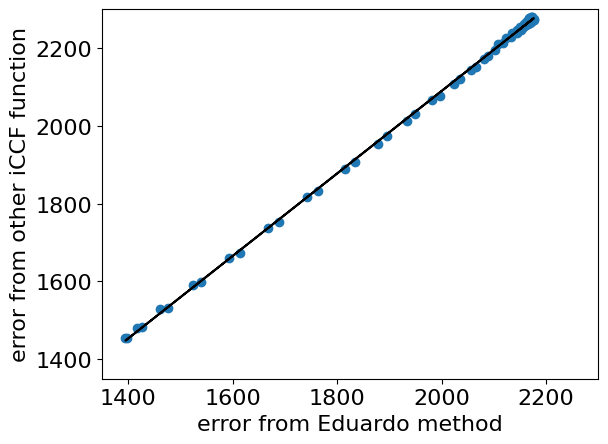

In [ ]:
plt.figure()

poly_coefs, poly_cov = np.polyfit(std_ccf, ccf[1], deg=1, cov=True)
plt.plot(std_ccf, poly_coefs[0]*std_ccf + poly_coefs[1], color="k")
print(poly_coefs, np.sqrt(np.diag(poly_cov)))
plt.scatter(std_ccf, ccf[1])
plt.xlim([1350,2300])
plt.ylim([1350,2300])
plt.xlabel("error from Eduardo method")
plt.ylabel("error from other iCCF function")
plt.show()

In [13]:
CCFs_weak_iron = np.zeros((len(list_spectra), 2, RV_table.shape[0]))

for i in tqdm.tqdm(range(len(list_spectra))):

    hdul = fits.open(list_spectra[i])
    tbl = hdul[1].data   
    wavelength = np.array(tbl.field(1))
    flux = np.array(tbl.field(2))
    flux_error = np.array(tbl.field(3))
    quality = np.array(tbl.field(4))
    berv = hdul[0].header['HIERARCH ESO QC BERV']
    hdul.close()

    ccf = iCCF.meta.espdr_compute_CCF_fast(ll = wavelength,
                                dll = np.gradient(wavelength),
                                flux = flux,
                                error = flux_error,
                                blaze = np.ones_like(flux),
                                quality = quality,
                                RV_table = RV_table,
                                mask = mask,
                                berv = berv,
                                bervmax = np.max(np.abs(RV_table)),
                                mask_width = 0.5)
    
    CCFs_weak_iron[i,0] = ccf[0]
    CCFs_weak_iron[i,1] = ccf[1]

100%|██████████| 40/40 [00:03<00:00, 12.14it/s]


In [14]:
Time = []
Air = []

for i,name in enumerate(list_spectra):
    h = fits.getheader(name)
    t = h['HIERARCH ESO QC BJD']
    air = h['HIERARCH ESO TEL1 AIRM START']
    Time.append(t)
    Air.append(air)
    
Time = np.array(Time)
Air = np.array(Air)

## Fitting modified gaussian

In [15]:
from scipy.optimize import curve_fit

def modified_gaussfit(x,y0,a,x0,sigma,c):
    return y0-a*np.exp(-0.5*((np.abs(x-x0)/sigma)**c))

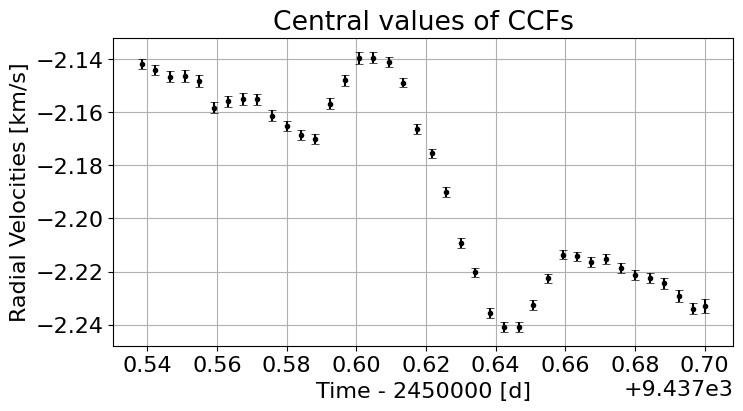

In [16]:
y0 = np.zeros((len(list_spectra),2))
x0 = np.zeros((len(list_spectra),2))

for i in range(len(list_spectra)):
    d = CCFs_weak_iron[i,0]
    de = CCFs_weak_iron[i,1]
    rv = RV_table

    p0 =          [np.max(d), np.max(d)-np.min(d),           0,       1,       1] #y0, a, x0, sigma, c
    upper_bound = [   np.inf,              np.inf,  np.max(rv),  np.inf,  np.inf]
    lower_bound = [        0,                   0,  np.min(rv),       0,       0]

    popt, pcov = curve_fit(f=modified_gaussfit, xdata=rv, ydata=d, sigma=de, 
                           bounds=(lower_bound,upper_bound), absolute_sigma=True, p0=p0)

    x0[i,0], x0[i,1] = popt[2], np.sqrt(pcov[2,2])
    y0[i,0], y0[i,1] = popt[0], np.sqrt(pcov[0,0])

    #plt.figure()
    #plt.errorbar(rv,d,de, fmt="k.")
    #plt.plot(rv, modified_gaussfit(rv, popt[0], popt[1], popt[2], popt[3], popt[4]))
    #plt.show()
    #print(x0)

plt.figure(figsize=(8,4))
plt.errorbar(x=Time-2450000, y=x0[:,0], yerr=x0[:,1], capsize=3, capthick=0.5, fmt="k.")
plt.ylabel('Radial Velocities [km/s]')
plt.xlabel('Time - 2450000 [d]')
plt.title('Central values of CCFs')
plt.grid()
plt.show()


In [17]:
def phase(date,tepoch, P_orb):
    norb = (date-tepoch)/P_orb
    nforb = [round(x) for x in norb]
    return norb-nforb

In [18]:
#cristo et al.
#table 4
Vsys = -2.18095 #km/s
Prot = 11.454 #dias
istar = 71.87 #º
alphaB = 0.29
VCB = -211 #m/s
ip = 85.465 #º
lamda = -1.00 #º
aR = 8.7686 #in star radiuses
RpRs = 0.1602
mp =  356.9 #m⊕
dfp = -0.002424
alphaw = -50.4 #cm/s
#table E.1
Rstar = 0.766 #R⊙
Teff = 4969 #K
e_Teff = 43
P_orb = 2.21857312 #dias
T0 = 53988.30339

logg = 4.60 
e_logg = 0.01
feh = -0.07
e_feh = 0.02

In [19]:
tepoch = T0 + 0.5+2.4e6 -dfp*P_orb#MBJD

phases = phase(Time, tepoch, P_orb)
print(phases) #em Porbit

[-0.03877965 -0.03699807 -0.03513644 -0.03317754 -0.03131976 -0.02944458
 -0.02757342 -0.02563591 -0.02378865 -0.02190919 -0.02001656 -0.01811592
 -0.01627109 -0.01440934 -0.01248778 -0.01064714 -0.00877745 -0.00681717
 -0.00498954 -0.00311065 -0.00125441  0.00063656  0.00255225  0.00441426
  0.00628021  0.00818162  0.01005535  0.01194012  0.01380782  0.01570125
  0.01754502  0.01942622  0.02132599  0.02322993  0.02504088  0.0270019
  0.02884832  0.03072907  0.03260807  0.03417421]


In [20]:
tr_dur=1./np.pi * np.arcsin(1./aR *np.sqrt((1+RpRs)**2.-aR**2. *np.cos(np.radians(ip))**2.))

tr_ingress_egress=1./np.pi * np.arcsin(1./aR *np.sqrt((1.-RpRs)**2.-aR**2. *np.cos(np.radians(ip))**2.))

Text(0.5, 1.0, 'Airmass at start of observation in function of orbital phases')

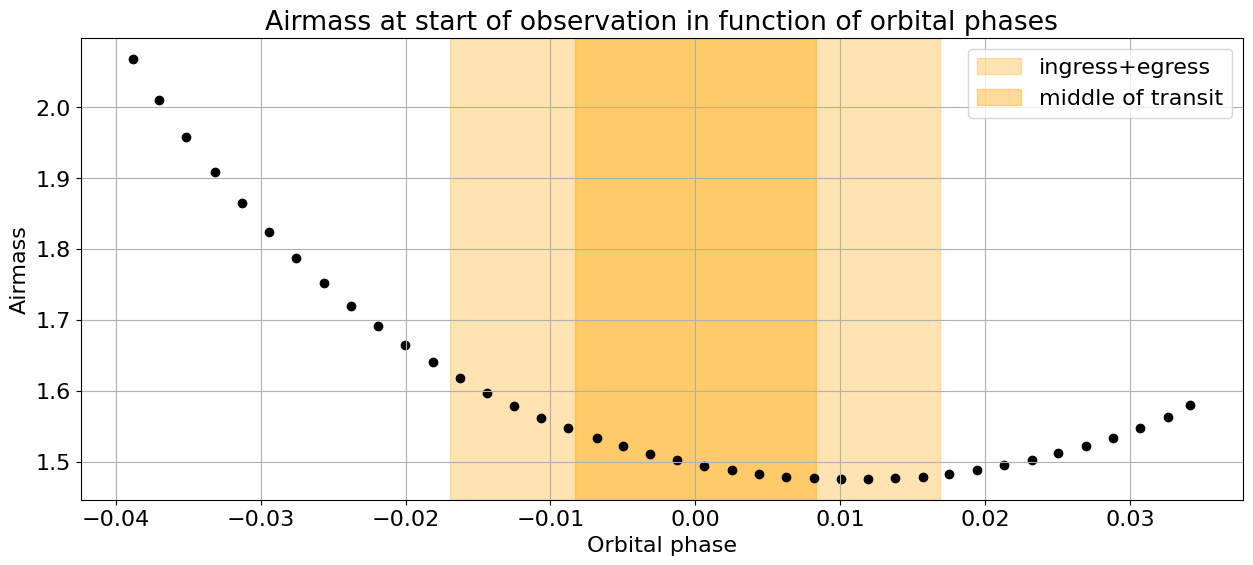

In [21]:
plt.figure(figsize=(15,6))
plt.axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange',label='ingress+egress')
plt.axvspan(tr_ingress_egress/2.-tr_dur/2, -tr_ingress_egress/2.+tr_dur/2, alpha=0.4, color='orange',label='middle of transit')
plt.scatter(phases, Air,color='black')
plt.xlabel('Orbital phase')
plt.grid()
plt.ylabel('Airmass')
plt.legend()
plt.title('Airmass at start of observation in function of orbital phases')

## RV correction and normalization

In [22]:
out_indices = np.where(np.abs(phases) >  tr_dur/2)[0]
in_indices  = np.where(np.abs(phases) <= tr_dur/2)[0]

poly_coefs, poly_cov = np.polyfit(phases[out_indices], x0[:,0][out_indices], w=1/x0[:,1][out_indices],deg=1,cov=True)

x0_corr = np.zeros_like(x0)
CCFs_corr = np.zeros_like(CCFs_weak_iron)
CCF_rv_corr = np.zeros((len(list_spectra), RV_table.shape[0]))

for i in range(len(list_spectra)):
    d = CCFs_weak_iron[i,0]
    de = CCFs_weak_iron[i,1]
    
    d_corr = d/y0[i,0]
    
    x0_corr[i,0] = x0[i,0] - (poly_coefs[0]*phases[i] + poly_coefs[1])
    CCF_rv_corr[i] = RV_table - (poly_coefs[0]*phases[i] + poly_coefs[1])
    CCFs_corr[i,0] = d_corr

    CCFs_corr[i,1] = d_corr * np.sqrt( (y0[i,1]/y0[i,0])**2 + (de/d)**2 )
    x0_corr[i,1] = np.sqrt( x0[i,1]**2 + poly_cov[0,0]*phases[i]**2 + poly_cov[1,1])

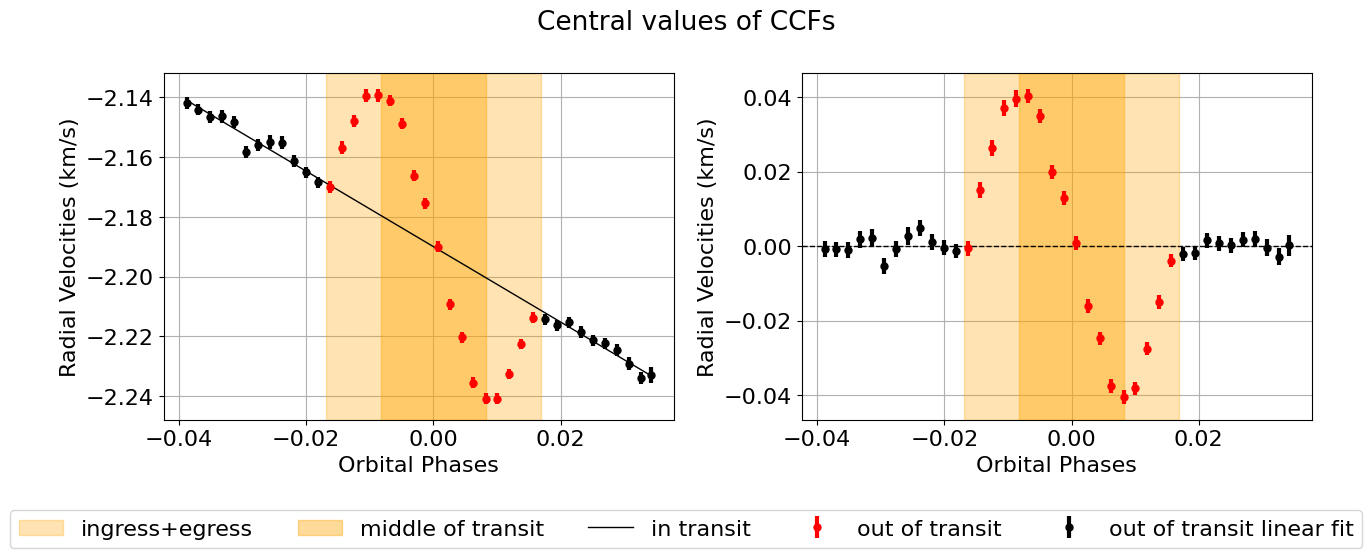

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(13,5))

l0 = axes[0].axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange')
l1 = axes[0].axvspan(tr_ingress_egress/2.-tr_dur/2, -tr_ingress_egress/2.+tr_dur/2, alpha=0.4, color='orange')
l2 = axes[0].errorbar(phases[in_indices], x0[:,0][in_indices], x0[:,1][in_indices], fmt="r.", markersize=10, elinewidth=3)
l3 = axes[0].errorbar(phases[out_indices], x0[:,0][out_indices], x0[:,1][out_indices], fmt="k.", markersize=10, elinewidth=3)
l4 = axes[0].plot(phases[out_indices], poly_coefs[0]*phases[out_indices]+poly_coefs[1], color="black", lw=1)

axes[0].set_ylabel('Radial Velocities (km/s)')
axes[0].set_xlabel('Orbital Phases')
axes[0].grid()
axes[0].set_axisbelow(True)


axes[1].axvspan(-tr_dur/2, tr_dur/2, alpha=0.3, color="orange")
axes[1].axvspan(tr_ingress_egress/2.-tr_dur/2, -tr_ingress_egress/2.+tr_dur/2, alpha=0.4, color='orange')
axes[1].errorbar(phases[in_indices], x0_corr[:,0][in_indices], x0_corr[:,1][in_indices], fmt="r.", markersize=10, elinewidth=3)
axes[1].errorbar(phases[out_indices], x0_corr[:,0][out_indices], x0_corr[:,1][out_indices], fmt="k.", markersize=10, elinewidth=3)
axes[1].axhline(0, lw=1, ls= "--", color="k")
axes[1].set_ylabel('Radial Velocities (km/s)')
axes[1].set_xlabel('Orbital Phases')
axes[1].grid()
axes[1].set_axisbelow(True)

labels = ['ingress+egress','middle of transit','in transit','out of transit','out of transit linear fit']
fig.legend([l0,l1,l2,l3,l4], labels=labels, loc='lower center',ncol=5, bbox_to_anchor=(0.5, -0.12))
fig.suptitle('Central values of CCFs',fontsize=19)

plt.tight_layout()
plt.show()

In [26]:
M = CCFs_corr.shape[0]
K = CCFs_corr.shape[2]
cov_matrix = np.zeros((M, K, K))
N = 10000

for i in range(M):
    samples = np.zeros((K, N))
    for j in range(K):
        ymean = CCFs_corr[i,0,j]
        ysigma = CCFs_corr[i,1,j]
        samples[j,:] = np.random.normal(ymean, ysigma, N)
    cov_ccf = np.cov(samples)
    cov_matrix[i,:,:] = cov_ccf

In [27]:
def linear_interpolation_matrix(x_old, x_new):
    """
    Builds a sparse matrix W that linearly interpolates data from x_old → x_new.
    Each row i corresponds to interpolation weights for x_new[i].
    """
    W = lil_matrix((len(x_new), len(x_old)))

    for i, xv in enumerate(x_new):
        if xv <= x_old[0]:
            # extrapolate using first two points
            j = 0
            x0, x1 = x_old[j], x_old[j+1]
            w1 = (x1 - xv) / (x1 - x0)
            w2 = (xv - x0) / (x1 - x0)
        elif xv >= x_old[-1]:
            # extrapolate using last two points
            j = len(x_old) - 2
            x0, x1 = x_old[j], x_old[j+1]
            w1 = (x1 - xv) / (x1 - x0)
            w2 = (xv - x0) / (x1 - x0)
        else:
            j = np.searchsorted(x_old, xv) - 1
            x0, x1 = x_old[j], x_old[j+1]
            w1 = (x1 - xv) / (x1 - x0)
            w2 = (xv - x0) / (x1 - x0)

        W[i, j]   = w1
        W[i, j+1] = w2

    return W.tocsr()


# Preallocate results
out_of_transit_CCFs = np.zeros([len(out_indices), len(RV_table), 2])
in_transit_CCF = np.zeros([CCFs_corr.shape[0] - len(out_indices), len(RV_table)])

interp_CCF_flux = np.zeros([CCFs_corr.shape[0], CCFs_corr.shape[2], 2])

k, M = 0, 0
RV_target = RV_table+2  # your adjusted target grid

for l in range(len(list_spectra)):
    ccf_f = CCFs_corr[l,0]
    ccf_f_e = cov_matrix[l]       # full covariance matrix
    ccf_rv = CCF_rv_corr[l]

    # Build interpolation matrix for this CCF → target grid
    W = linear_interpolation_matrix(ccf_rv, RV_target)

    # Interpolated flux
    y_i = W @ ccf_f

    # Propagated covariance and uncertainty
    cov_new = W @ ccf_f_e @ W.T
    y_i_e = np.sqrt(cov_new.diagonal())

    interp_CCF_flux[l,:,0] = y_i
    interp_CCF_flux[l,:,1] = y_i_e

    # Separate out-of-transit vs in-transit
    if l in out_indices:
        out_of_transit_CCFs[k,:,0] = y_i
        out_of_transit_CCFs[k,:,1] = y_i_e
        k += 1
    else:
        in_transit_CCF[M] = y_i
        M += 1

# Compute master out-of-transit CCF and its uncertainty
average_out_of_transit_CCF = np.mean(out_of_transit_CCFs[:,:,0], axis=0)
A_e = np.sum(out_of_transit_CCFs[:,:,1]**2, axis=0)
average_out_of_transit_CCF_e = np.sqrt(A_e) / len(out_indices)


avg_out_of_transit_CCF = np.array([average_out_of_transit_CCF, average_out_of_transit_CCF_e])
avg_out_of_transit_CCF

array([[9.96380420e-01, 9.96596536e-01, 9.96915972e-01, 9.97298558e-01,
        9.97707578e-01, 9.98135165e-01, 9.98811626e-01, 9.99635045e-01,
        1.00036612e+00, 1.00105543e+00, 1.00179146e+00, 1.00254219e+00,
        1.00314478e+00, 1.00368276e+00, 1.00423841e+00, 1.00463644e+00,
        1.00487084e+00, 1.00516013e+00, 1.00532432e+00, 1.00538771e+00,
        1.00533445e+00, 1.00506906e+00, 1.00450321e+00, 1.00363651e+00,
        1.00232774e+00, 1.00020436e+00, 9.97043614e-01, 9.92323203e-01,
        9.85296809e-01, 9.75460344e-01, 9.62268643e-01, 9.45127746e-01,
        9.23689713e-01, 8.98347838e-01, 8.69990120e-01, 8.39976897e-01,
        8.10353931e-01, 7.83582052e-01, 7.62029921e-01, 7.48017545e-01,
        7.43151598e-01, 7.47914499e-01, 7.61762391e-01, 7.83239231e-01,
        8.10189516e-01, 8.40024572e-01, 8.70138826e-01, 8.98586184e-01,
        9.23830122e-01, 9.45184451e-01, 9.62385894e-01, 9.75587792e-01,
        9.85357660e-01, 9.92594407e-01, 9.97697520e-01, 1.001227

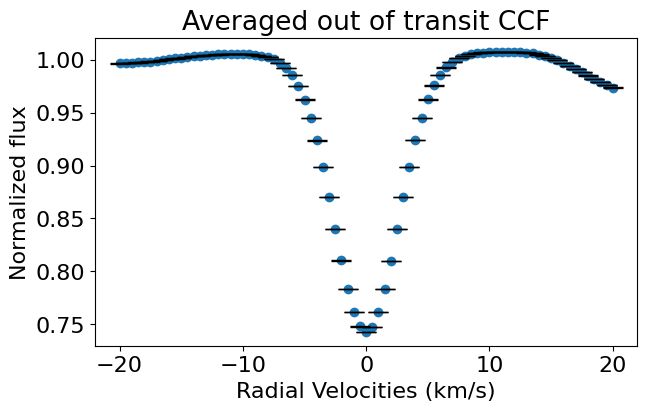

In [30]:
plt.figure(figsize=(7,4))
plt.scatter(RV_target, avg_out_of_transit_CCF[0])
plt.errorbar(x=RV_target, y=avg_out_of_transit_CCF[0],yerr =avg_out_of_transit_CCF[1],capsize=7,capthick=1,color='black',linewidth=0,elinewidth=1)
plt.title('Averaged out of transit CCF')
plt.xlabel('Radial Velocities (km/s)')
plt.ylabel('Normalized flux')
plt.show()

## Photometric light curve

In [31]:
#coeficientes de limb darkening
filters = [BoxcarFilter('filter', 380, 788)] #expresso spectograph bandpass 380, 788nm
sc = LDPSetCreator(teff=(Teff, e_Teff),  
logg=(logg, e_logg),
z=(feh, e_feh),
filters=filters)
ps = sc.create_profiles()      	         #create the limb darkening profiles
ldcn, qe = ps.coeffs_qd(do_mc=True) #coeficientes e os seus erros de perfil quadrático
ldcn

array([[0.64777446, 0.07918295]])

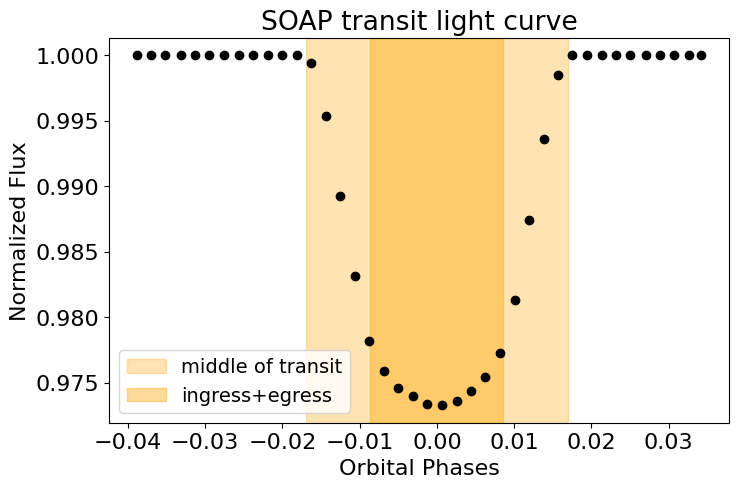

In [32]:
#curva de luz
sim = SOAP.Simulation()
sim.star.set(prot = Prot,incl =istar,radius=Rstar,teff=Teff,u1=ldcn[0,0], u2=ldcn[0,1])
sim.planet.set(P=P_orb, t0=0, e=0.0, w=90.0,ip=ip,lbda=lamda,a=aR,Rp=RpRs)

output = sim.calculate_signal(psi=phases/Prot*P_orb,skip_rv=True)
Flux_SOAP = output.flux

fig = plt.figure(figsize=(8,5))

plt.axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange', label="middle of transit")
plt.axvspan(-tr_ingress_egress/2., tr_ingress_egress/2., alpha=0.4, color='orange', label="ingress+egress")
plt.scatter(phases, Flux_SOAP, color="k")
plt.title('SOAP transit light curve')
plt.ylabel("Normalized Flux")
plt.xlabel("Orbital Phases")
plt.legend(fontsize=14)

plt.show()

## Local strong Iron lines CCFs

In [33]:
CCFs_flux_corr = np.zeros_like(CCFs_corr) #only flux corrected
CCFs_sub_all = np.zeros_like(CCFs_corr) #flux corrected and subtracted
local_CCFs = np.zeros((len(in_indices), 2, CCFs_corr.shape[2])) #above but only in transit

l = 0
for i in range(CCFs_flux_corr.shape[0]):

    d = interp_CCF_flux[i,:,0]
    de = interp_CCF_flux[i,:,1]
    
    #performing the Doppler shadow technique
    sub = avg_out_of_transit_CCF[0] - d*Flux_SOAP[i]

    d_corr = d/Flux_SOAP[i]
    de_corr = np.sqrt(avg_out_of_transit_CCF[1]**2+(de*Flux_SOAP[i])**2)

    CCFs_sub_all[i,0] = sub
    CCFs_sub_all[i,1] = de_corr

    if i in in_indices:
        
        CCFs_flux_corr[i,0] = d_corr
        CCFs_flux_corr[i,1] = de*Flux_SOAP[i]

        local_CCFs[l,0] = sub
        local_CCFs[l,1] = de_corr

        l += 1

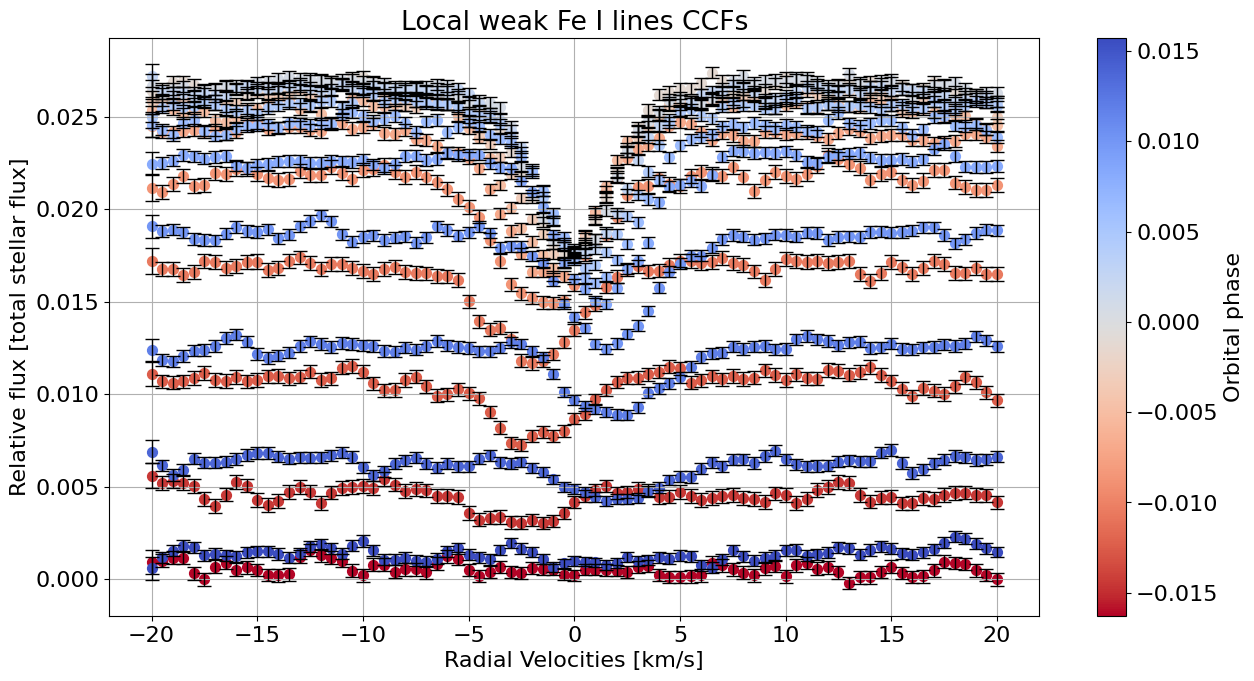

In [36]:
fig, axes = plt.subplots(figsize=(15,7.5))

norm = Normalize(vmin=phases[in_indices].min(), vmax=phases[in_indices].max())
cmap = plt.get_cmap('coolwarm_r')

for k, idx in enumerate(in_indices):

    sub     = local_CCFs[k,0]
    de_corr = local_CCFs[k,1]

    color = cmap(norm(phases[idx]))

    axes.scatter(RV_target, sub, color=color, s=50, label=str(phases[idx])[:6])
    axes.errorbar(RV_target, sub, yerr=de_corr,
                    color='black', capsize=5, linewidth=0, elinewidth=1)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = fig.colorbar(sm, ax=axes)
cbar.set_label('Orbital phase')

axes.set_title('Local weak Fe I lines CCFs')
axes.set_ylabel('Relative flux [total stellar flux]')
axes.set_xlabel('Radial Velocities [km/s]')
axes.grid()
plt.show()

## Fits

In [37]:
def r2(y,yfit):
    ssres = np.sum((y-yfit)**2)
    sstot = np.sum((y-np.mean(y))**2)
    r = 1- ssres/sstot
    return r

In [38]:
#impact parameter
b = aR*np.cos(ip*np.pi/180)

# calculating minimum and maximum mu for the shaded regions in the plots
def mu(phases):
    return np.sqrt(1 - b**2 - (aR*np.sin(2*np.pi*np.abs(phases)))**2 )
mu_min = mu(tr_dur/2-tr_ingress_egress/2)
mu_max = mu(0)

y_0 = 1.0002±1.0597, a = 0 ±3.8142, x_0 = -0.000245 ± 0.000324, sigma = 2.5930±0.0005, c = 2.0636±0.0008


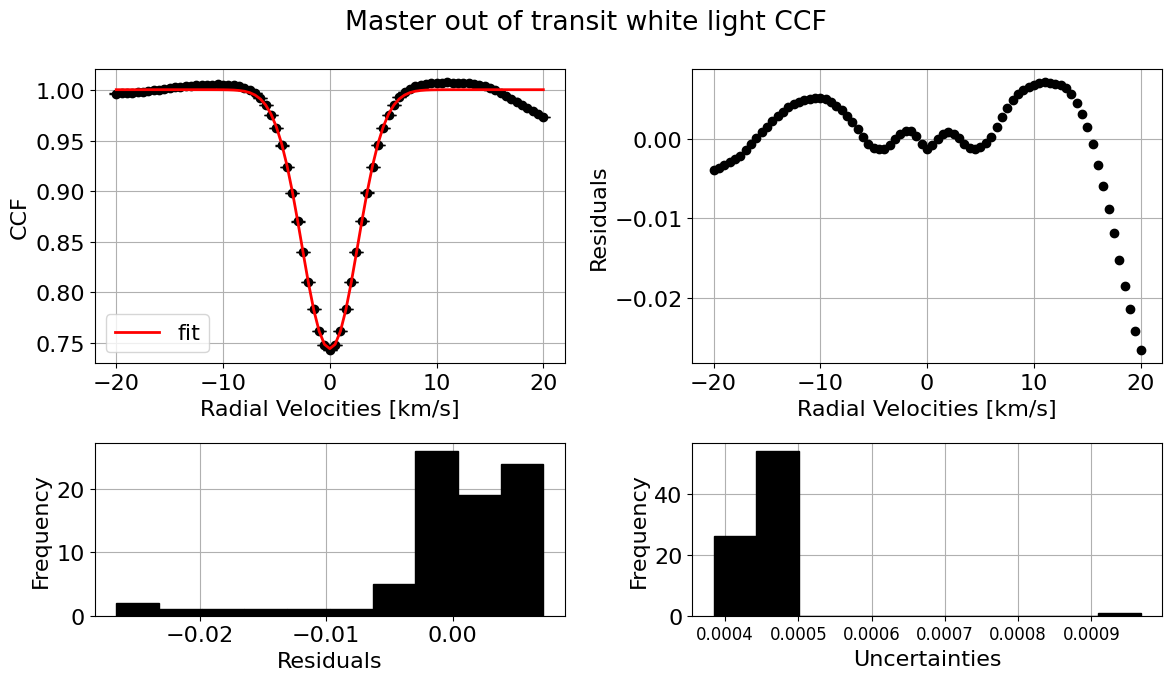

R^2:  0.9925449475644349


In [39]:
#MASTER OUT OF TRANSIT parameter fitting for comparison
p0 =          [np.max(avg_out_of_transit_CCF[0]), np.max(avg_out_of_transit_CCF[0])-np.min(avg_out_of_transit_CCF[0]),           0,       1,       1] #y0, a, x0, sigma, c
upper_bound = [   np.inf,              np.inf,  np.max(rv),  np.inf,  np.inf]
lower_bound = [        0,                   0,  np.min(rv),       0,       0]


popt, pcov = curve_fit(f=modified_gaussfit, xdata=RV_target, ydata=avg_out_of_transit_CCF[0], sigma=avg_out_of_transit_CCF[1], bounds=(lower_bound,upper_bound), absolute_sigma=True, p0=p0)
gd = modified_gaussfit(RV_target,popt[0],popt[1],popt[2],popt[3],popt[4])

print('y_0 = '+str(popt[0])[:6]+'±'+str(np.sqrt(pcov[0,0]))[:6]+f', a = {popt[1]:.0f} ±'+str(np.sqrt(pcov[1,1]))[:6]+f', x_0 = {popt[2]:.06f} ± {np.sqrt(pcov[2,2]):.06f}, sigma = '+str(popt[3])[:6]+'±'+str(np.sqrt(pcov[3,3]))[:6]+', c = '+str(popt[4])[:6]+'±'+str(np.sqrt(pcov[4,4]))[:6])

master_x0 = popt[2]
master_x0_err = np.sqrt(pcov[2,2])

master_depth = (1-(popt[1]/popt[0]))*100
master_depth_err = ((popt[1]/popt[0])*np.sqrt(np.abs(pcov[1,1])/(popt[1]**2)+np.abs(pcov[0,0])/(popt[0]**2)))*100

master_width = popt[3] 
master_width_err = np.sqrt(pcov[3,3])

master_y0 = (popt[0])
master_y0_err = np.sqrt(pcov[0,0])


fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,7), gridspec_kw={'height_ratios': [1.7, 1]})
fig.suptitle('Master out of transit white light CCF')

axes[0,0].scatter(RV_target, avg_out_of_transit_CCF[0], color="k")
axes[0,0].errorbar(RV_target, avg_out_of_transit_CCF[0], yerr=avg_out_of_transit_CCF[1],
                    color='black', capsize=5, linewidth=0, elinewidth=1)
axes[0,0].plot(RV_target,gd,label='fit', color="r", lw=2)
axes[0,0].set_xlabel('Radial Velocities [km/s]')
axes[0,0].set_ylabel('CCF')
axes[0,0].grid()
axes[0,0].set_axisbelow(True)
axes[0,0].legend()


axes[0,1].scatter(RV_target, avg_out_of_transit_CCF[0]-gd, color="k")
axes[0,1].set_xlabel('Radial Velocities [km/s]')
axes[0,1].set_ylabel('Residuals')
axes[0,1].grid()
axes[0,1].set_axisbelow(True)


axes[1,0].hist(avg_out_of_transit_CCF[0]-gd, bins=10, edgecolor='k', color="k")
axes[1,0].set_xlabel('Residuals')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid()
axes[1,0].set_axisbelow(True)

axes[1,1].hist(de, bins=10, edgecolor='k', color="k")
axes[1,1].set_xlabel('Uncertainties')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid()
axes[1,1].set_axisbelow(True)
axes[1,1].tick_params(axis='x', which='major', labelsize=12)

plt.tight_layout()
plt.show()

print("R^2: ", r2(avg_out_of_transit_CCF[0],gd))

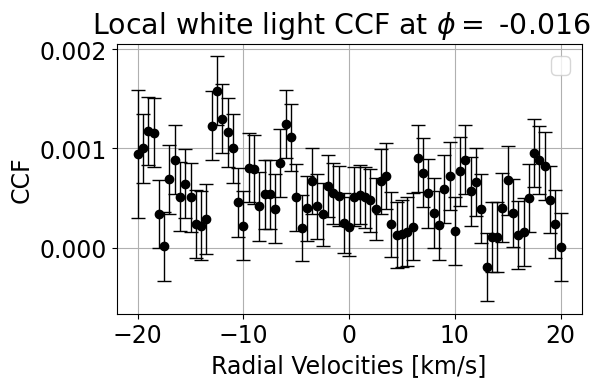

y_0 = 0.0046±4.4734, a = 0.0014±0.0001, x_0 = -2.686±0.1358, sigma = 2.3778±0.1823, c = 7.1524±3.9626


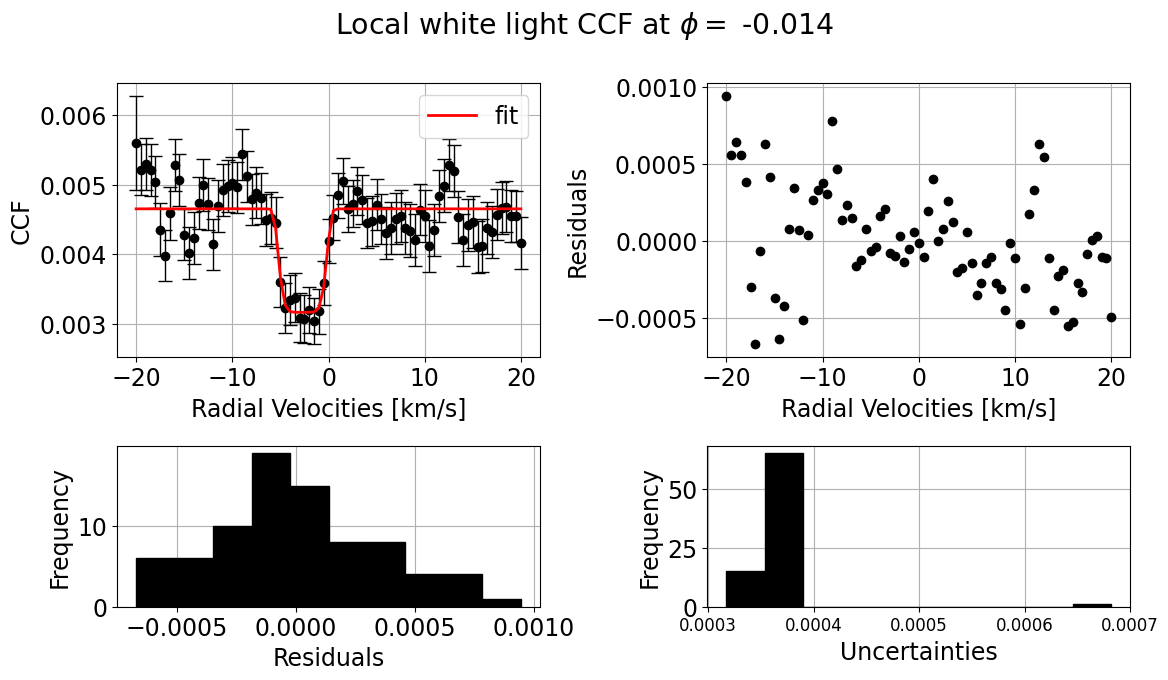

y_0 = 0.0108±4.6744, a = 0.0032±0.0001, x_0 = -1.914±0.0996, sigma = 2.1040±0.1732, c = 2.4529±0.4410


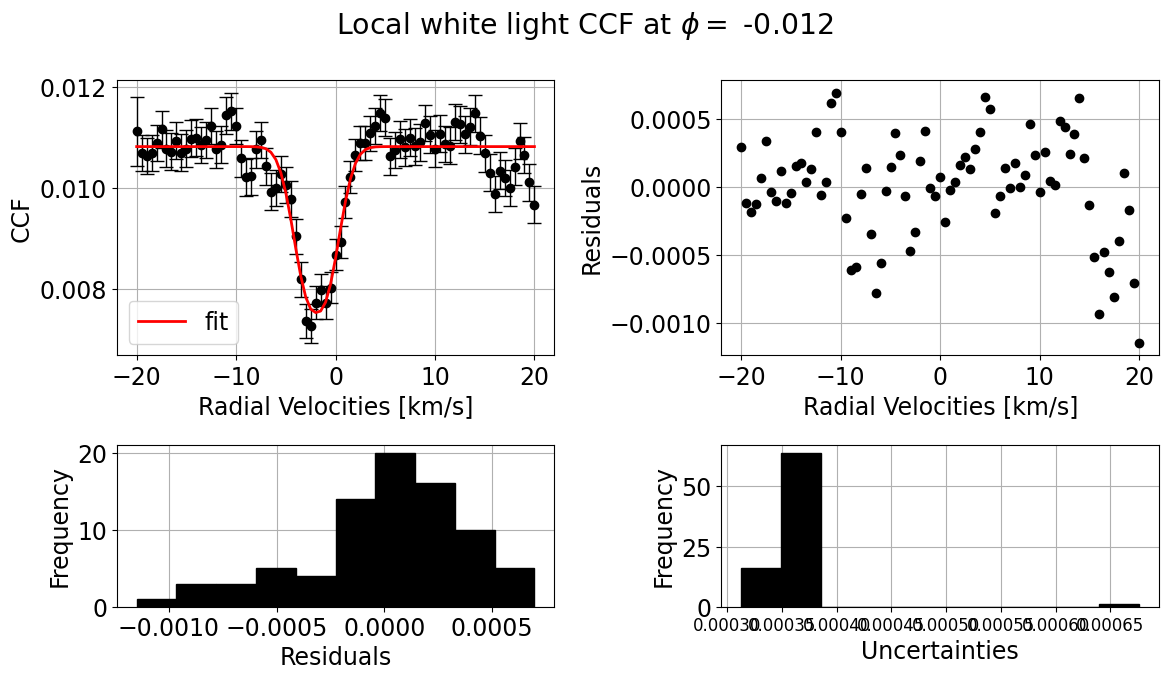

y_0 = 0.0168±4.9666, a = 0.0050±0.0002, x_0 = -1.932±0.0718, sigma = 2.1004±0.1327, c = 2.1283±0.2484


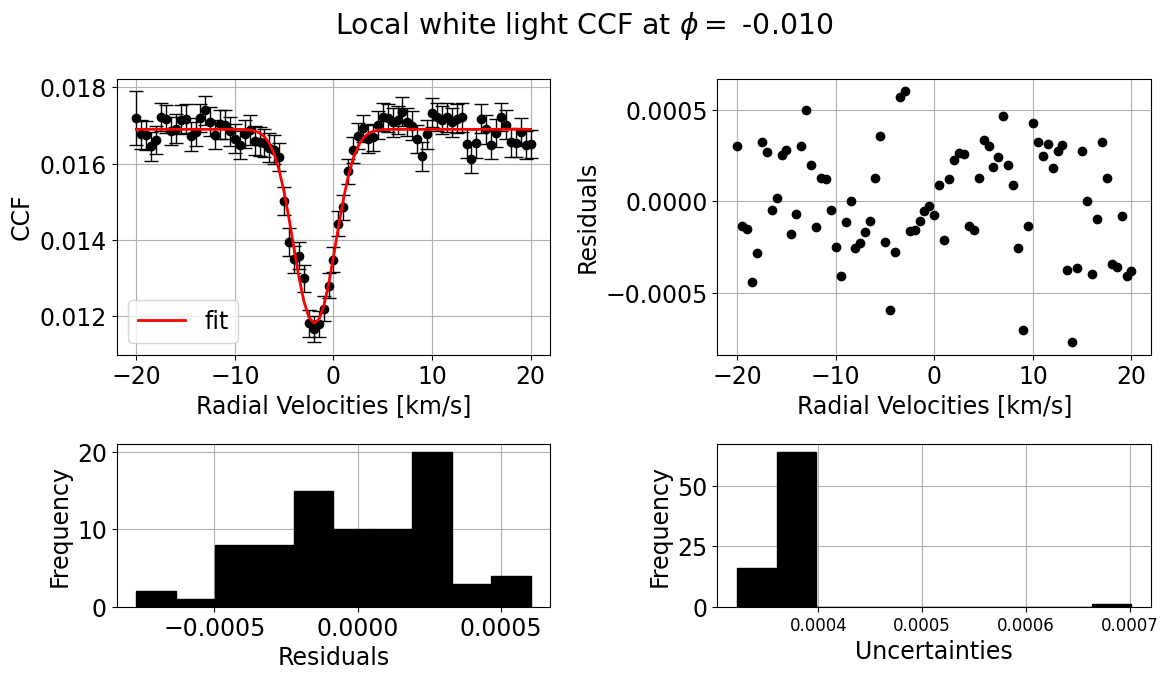

y_0 = 0.0218±5.0983, a = 0.0069±0.0002, x_0 = -1.438±0.0537, sigma = 2.2098±0.0982, c = 2.1496±0.1801


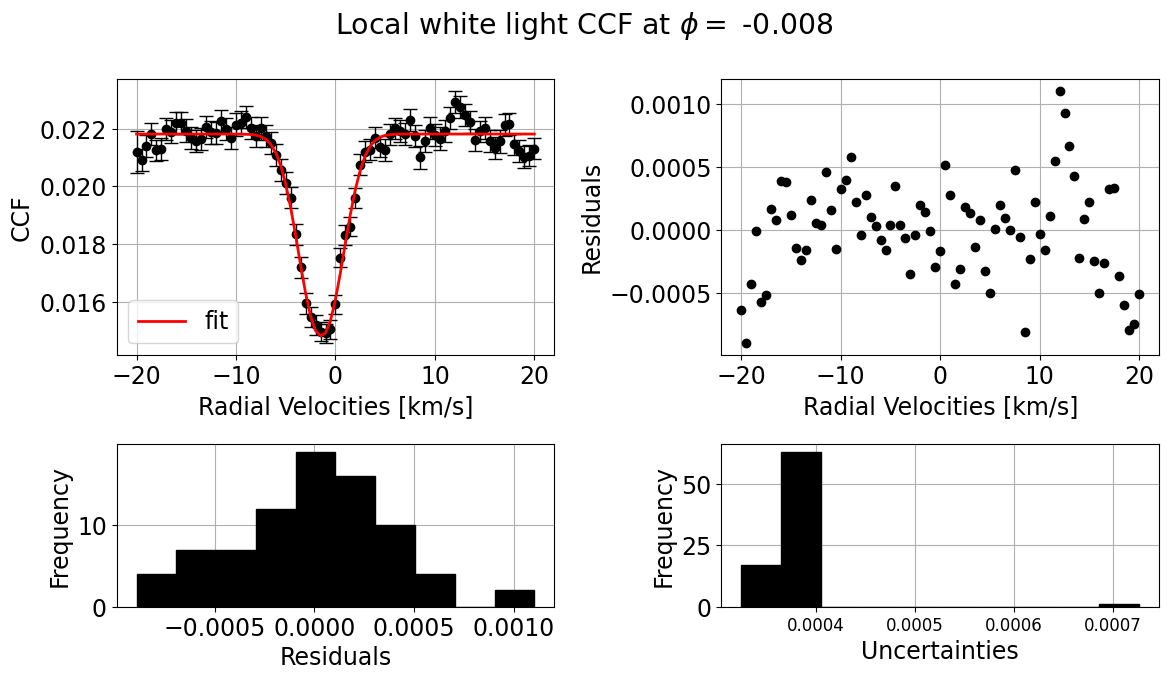

y_0 = 0.0241±4.3571, a = 0.0078±0.0001, x_0 = -1.219±0.0402, sigma = 2.0501±0.0761, c = 2.0151±0.1301


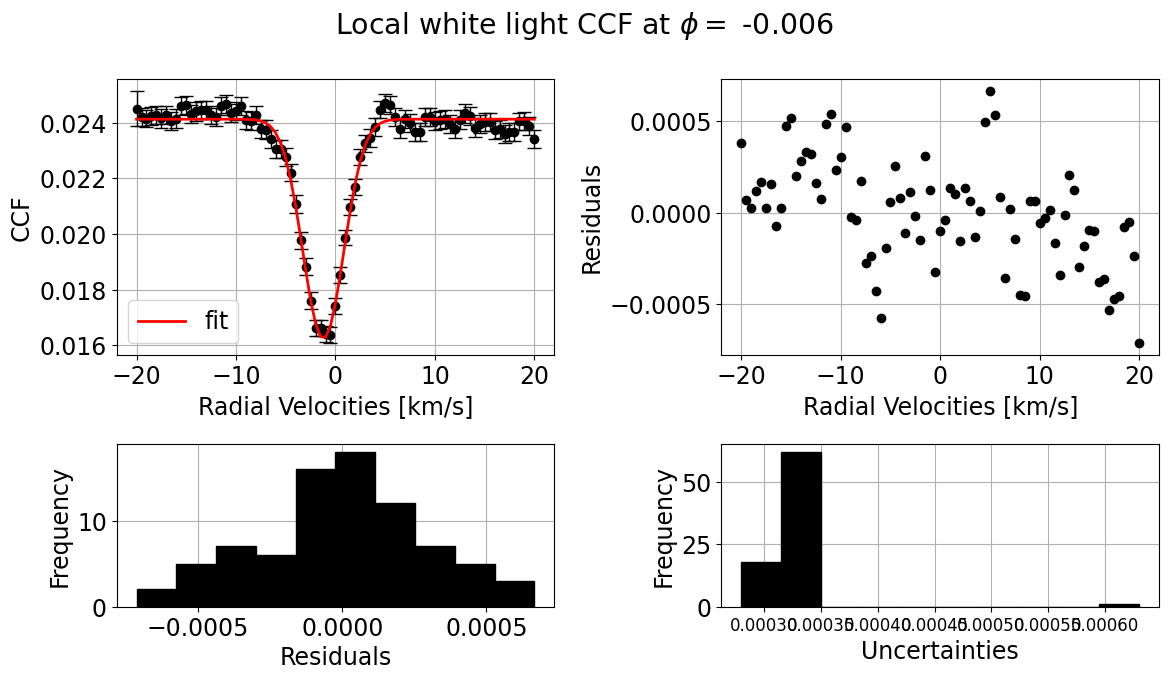

y_0 = 0.0254±4.1306, a = 0.0083±0.0001, x_0 = -0.936±0.0350, sigma = 2.1406±0.0620, c = 2.3084±0.1373


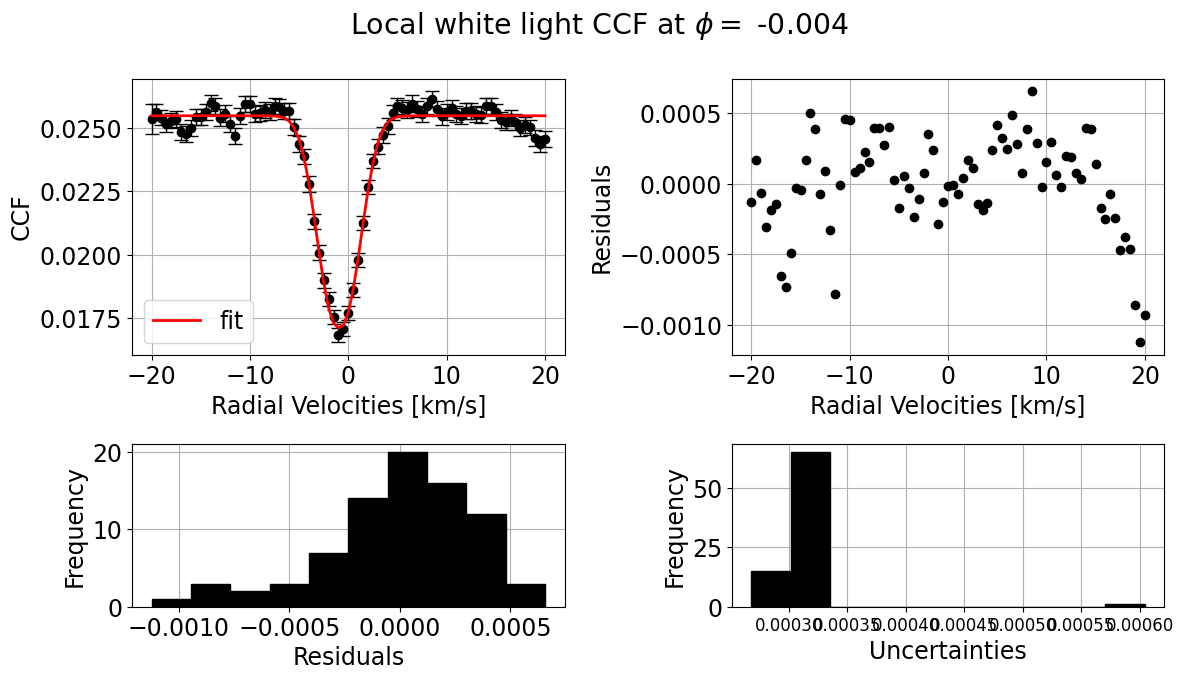

y_0 = 0.0260±4.2006, a = 0.0088±0.0001, x_0 = -0.527±0.0352, sigma = 1.9914±0.0699, c = 1.7659±0.0923


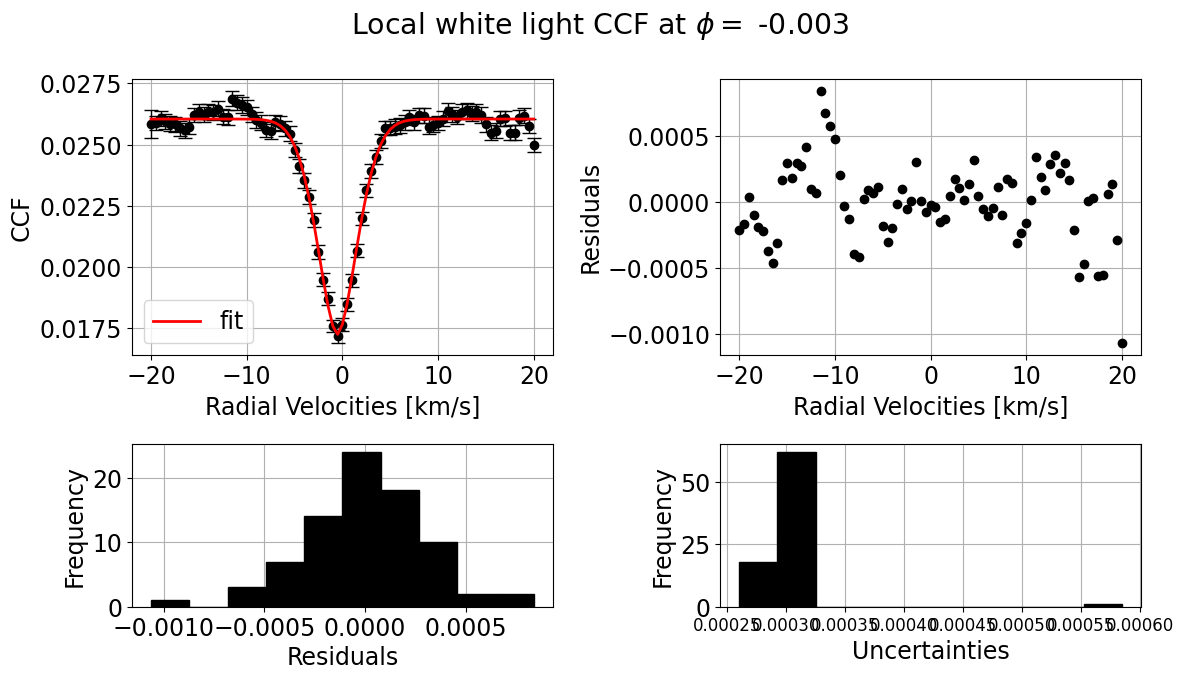

y_0 = 0.0266±4.0759, a = 0.0091±0.0001, x_0 = -0.295±0.0319, sigma = 1.9317±0.0613, c = 1.9362±0.1022


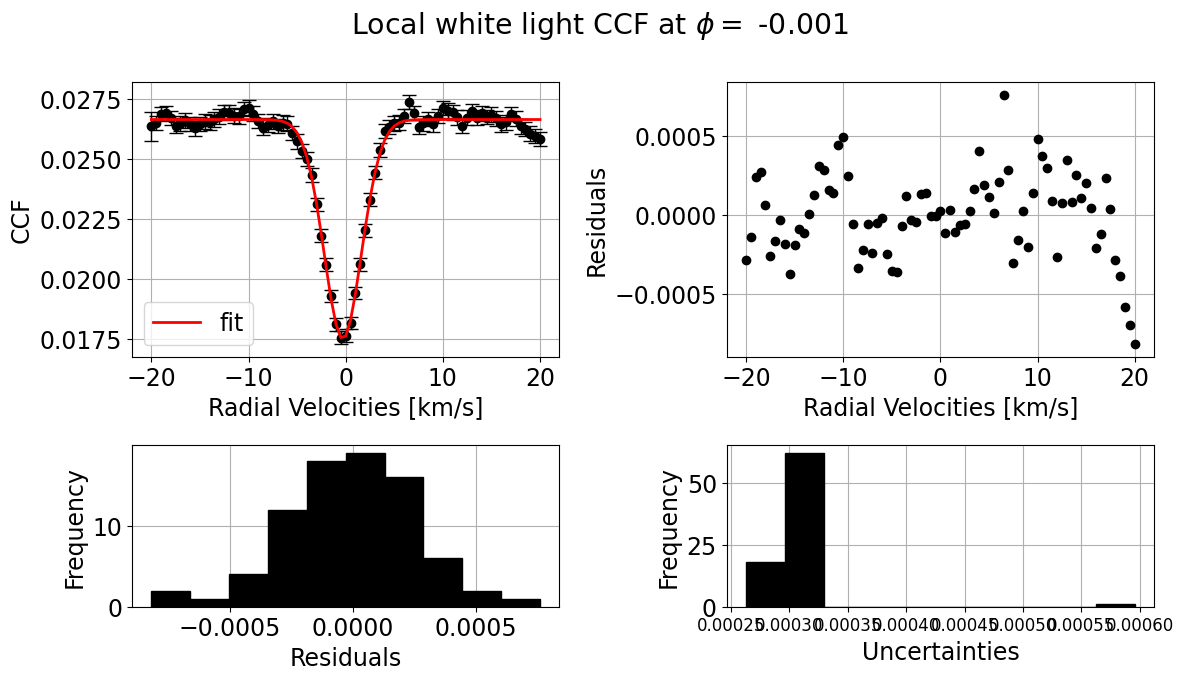

y_0 = 0.0266±4.1748, a = 0.0091±0.0001, x_0 = -0.045±0.0326, sigma = 1.9456±0.0611, c = 2.0250±0.1116


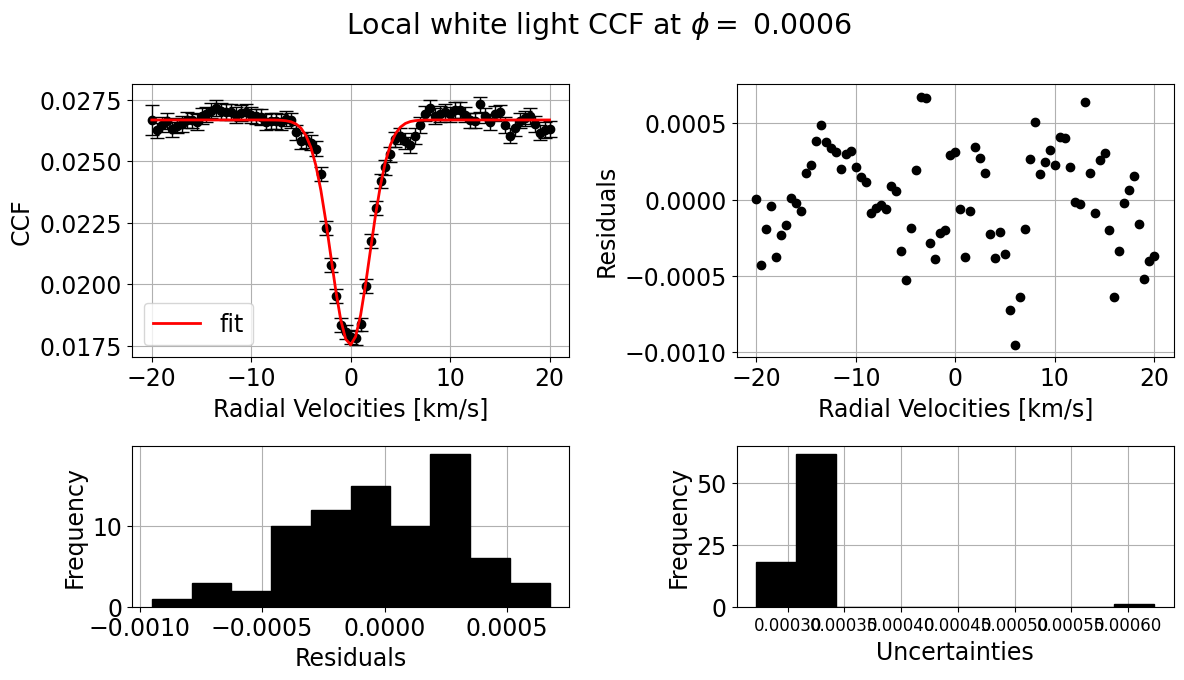

y_0 = 0.0263±4.2072, a = 0.0089±0.0001, x_0 = 0.4162±0.0344, sigma = 1.9796±0.0666, c = 1.8956±0.1033


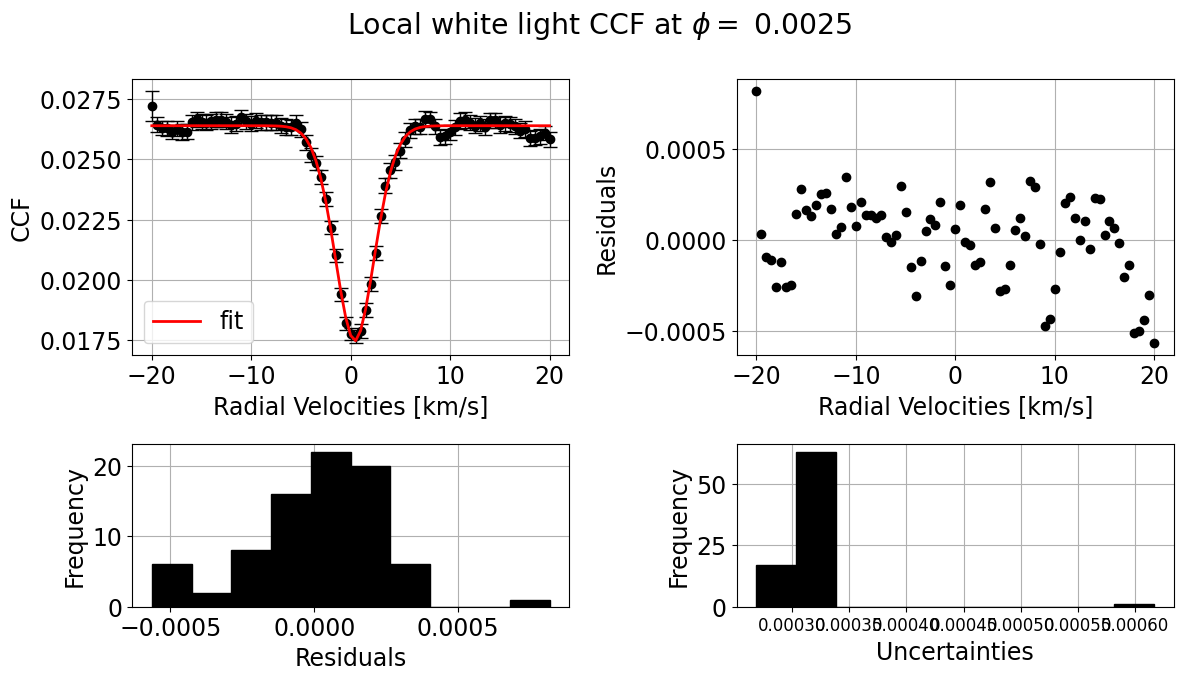

y_0 = 0.0256±3.9795, a = 0.0087±0.0001, x_0 = 0.6638±0.0332, sigma = 2.0655±0.0616, c = 2.0757±0.1119


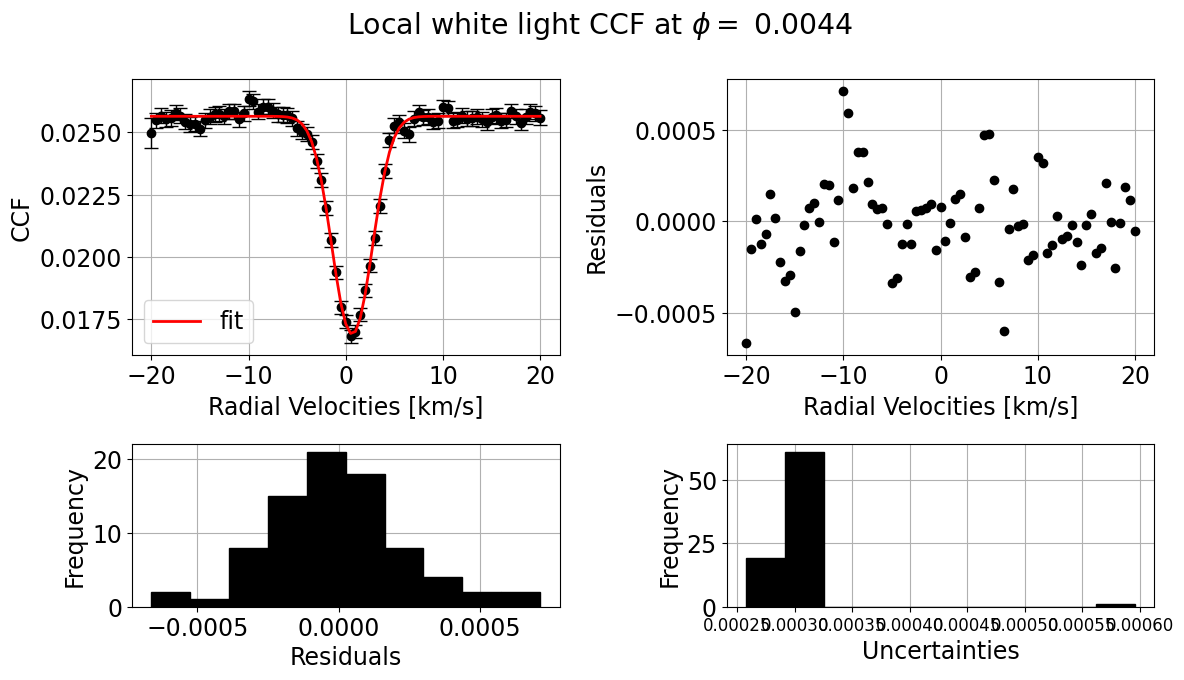

y_0 = 0.0245±4.1242, a = 0.0085±0.0001, x_0 = 1.0722±0.0350, sigma = 1.9213±0.0679, c = 1.8843±0.1065


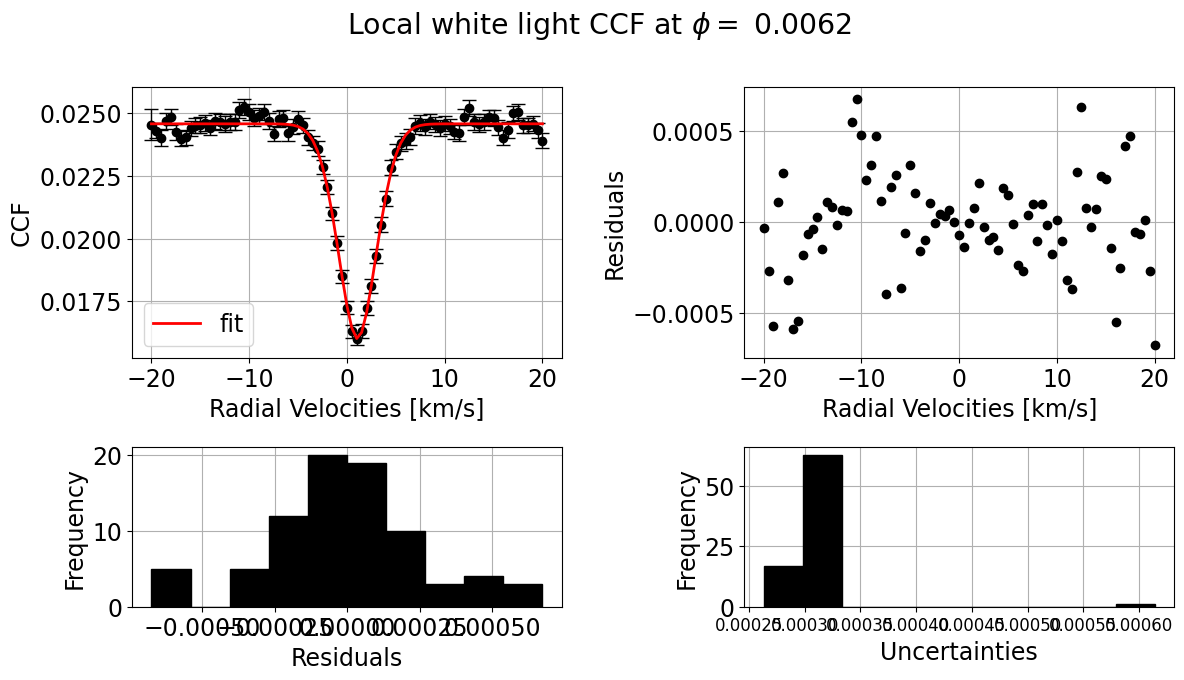

y_0 = 0.0227±4.1156, a = 0.0077±0.0001, x_0 = 1.2483±0.0385, sigma = 1.9804±0.0724, c = 2.0379±0.1314


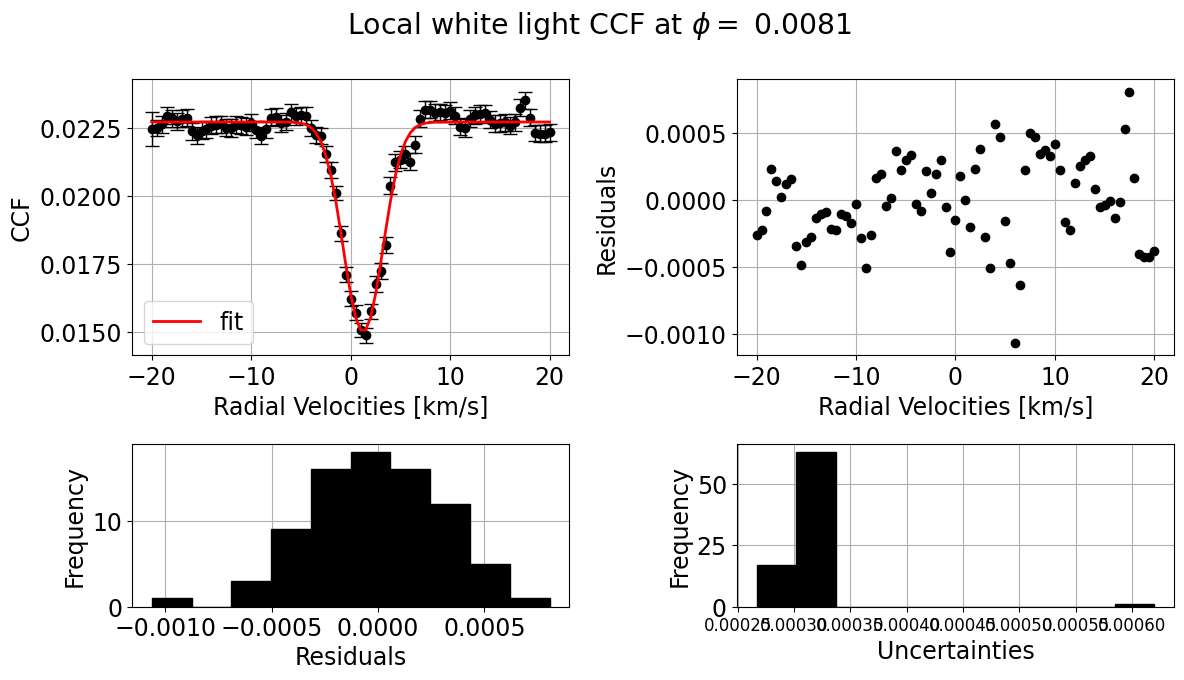

y_0 = 0.0186±4.1483, a = 0.0062±0.0001, x_0 = 1.6416±0.0494, sigma = 1.9794±0.0978, c = 1.8360±0.1403


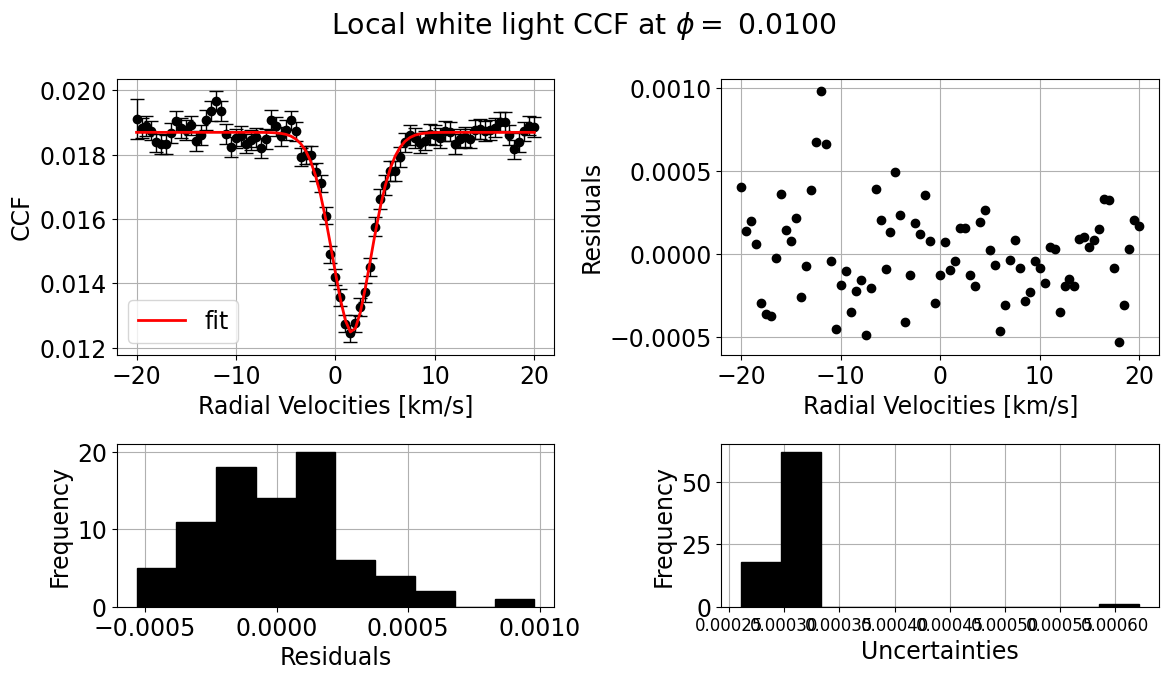

y_0 = 0.0125±3.9731, a = 0.0035±0.0001, x_0 = 1.9379±0.0779, sigma = 2.4159±0.1285, c = 2.8244±0.3901


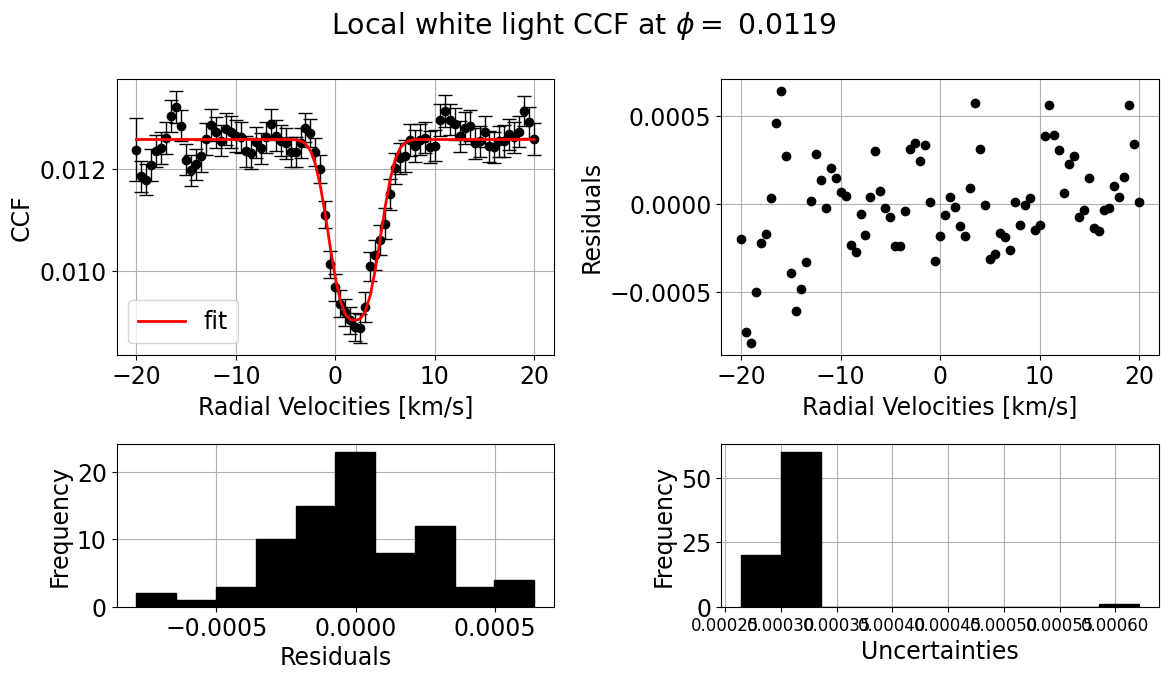

y_0 = 0.0063±4.0204, a = 0.0020±0.0001, x_0 = 1.9412±0.1431, sigma = 2.4200±0.2495, c = 2.4192±0.5403


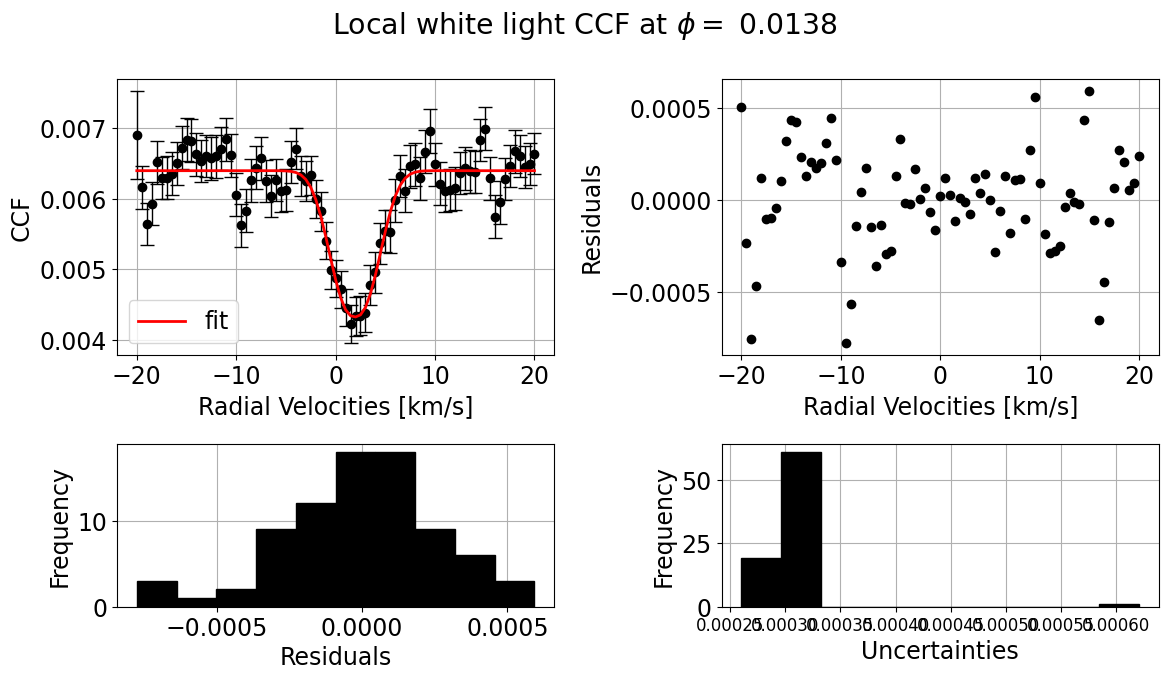

y_0 = 0.0016±0.0003, a = 0.0008±0.0005, x_0 = 1.5000±0.5539, sigma = 3.5662±2.3612, c = 0.9129±0.7842


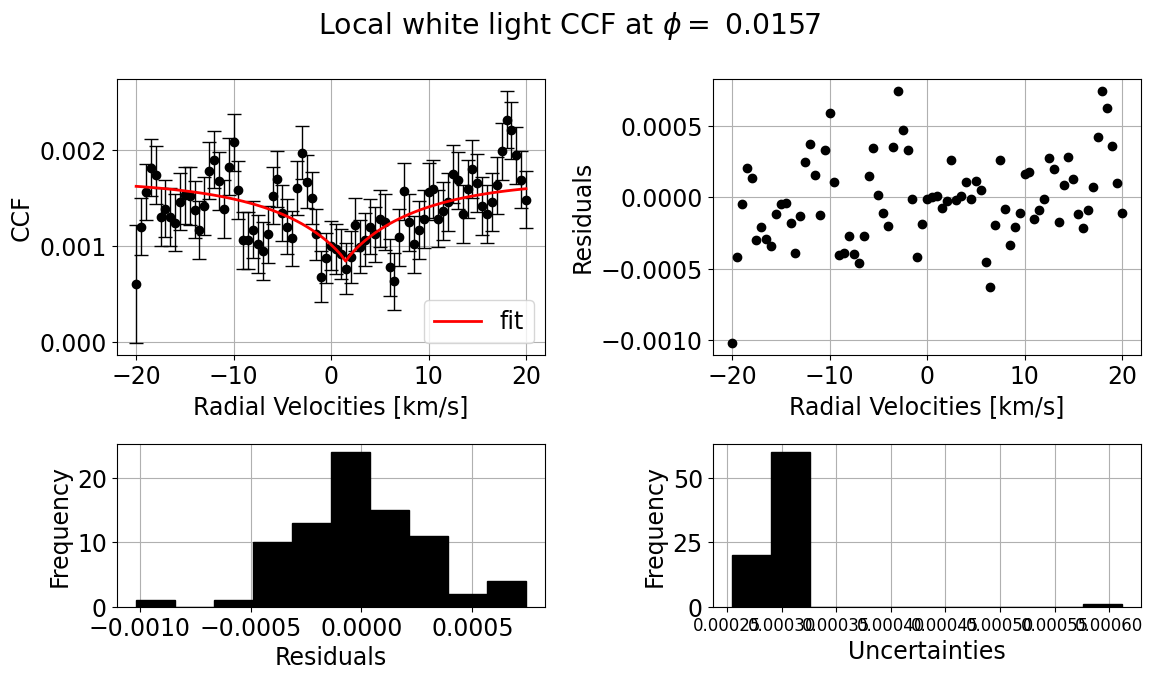

In [49]:
#in transit local CCFs parameter fitting
in_phases = phases[np.isin(np.arange(len(phases)), in_indices)]
mu_in = mu(in_phases)

y0_local = np.zeros((local_CCFs.shape[0],2))
x0_local = np.zeros((local_CCFs.shape[0],2))
width_local = np.zeros((local_CCFs.shape[0],2))
depth_local = np.zeros((local_CCFs.shape[0],2))

RR2 = []

for i in range(local_CCFs.shape[0]):

    d = local_CCFs[i,0]
    de = local_CCFs[i,1]

    p0 =          [np.max(d), np.max(d)-np.min(d),           0,       1,       1] #y0, a, x0, sigma, c
    upper_bound = [   np.inf,              np.inf,  np.max(rv),  np.inf,  np.inf]
    lower_bound = [        0,                   0,  np.min(rv),       0,       0]

    try:
        popt, pcov = curve_fit(f=modified_gaussfit, xdata=RV_target, ydata=d, sigma=de, 
                           bounds=(lower_bound,upper_bound), absolute_sigma=True, p0=p0)
    except:
        fig, axes = plt.subplots(figsize=(6,3.5))
        fig.suptitle(rf'Local white light CCF at $\phi = $ {str(in_phases[i])[:6]}')

        axes.scatter(RV_target, d, color="k")
        axes.errorbar(RV_target, d, yerr=de,
                        color='black', capsize=5, linewidth=0, elinewidth=1)
        axes.set_xlabel('Radial Velocities [km/s]')
        axes.set_ylabel('CCF')
        axes.grid()
        axes.set_axisbelow(True)
        axes.legend()
        plt.show()

        RR2.append(0)
        continue
    
    gd = modified_gaussfit(RV_target, popt[0], popt[1], popt[2], popt[3], popt[4])

    print('y_0 = '+str(popt[0])[:6]+'±'+str(np.sqrt(pcov[0,0]))[:6]+', a = '+str(popt[1])[:6]+'±'+str(np.sqrt(pcov[1,1]))[:6]+', x_0 = '+str(popt[2])[:6]+'±'+str(np.sqrt(pcov[2,2]))[:6]+', sigma = '+str(popt[3])[:6]+'±'+str(np.sqrt(pcov[3,3]))[:6]+', c = '+str(popt[4])[:6]+'±'+str(np.sqrt(pcov[4,4]))[:6])

    y0_local[i,0], y0_local[i,1] = popt[0], np.sqrt(pcov[0,0])
    x0_local[i,0], x0_local[i,1] = popt[2], np.sqrt(pcov[2,2])
    width_local[i,0], width_local[i,1] = popt[3], np.sqrt(pcov[3,3])
    depth_local[i,0], depth_local[i,1] = (1-popt[1]/popt[0])*100, ((popt[1]/popt[0])*np.sqrt(np.abs(pcov[1,1])/(popt[1]**2)+np.abs(pcov[0,0])/(popt[0]**2)))*100

    RR2.append(r2(d,gd))

        
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,7), gridspec_kw={'height_ratios': [1.7, 1]})
    fig.suptitle(rf'Local white light CCF at $\phi = $ {str(in_phases[i])[:6]}')

    axes[0,0].scatter(RV_target, d, color="k")
    axes[0,0].errorbar(RV_target, d, yerr=de,
                    color='black', capsize=5, linewidth=0, elinewidth=1)
    axes[0,0].plot(RV_target, gd, label='fit', color="r", lw=2)
    axes[0,0].set_xlabel('Radial Velocities [km/s]')
    axes[0,0].set_ylabel('CCF')
    axes[0,0].grid()
    axes[0,0].set_axisbelow(True)
    axes[0,0].legend()

    axes[0,1].scatter(RV_target, d-gd, color="k")
    axes[0,1].set_xlabel('Radial Velocities [km/s]')
    axes[0,1].set_ylabel('Residuals')
    axes[0,1].grid()
    axes[0,1].set_axisbelow(True)

    axes[1,0].hist(d-gd, bins=10, edgecolor='k', color="k")
    axes[1,0].set_xlabel('Residuals')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].grid()
    axes[1,0].set_axisbelow(True)

    axes[1,1].hist(de, bins=10, edgecolor='k', color="k")
    axes[1,1].set_xlabel('Uncertainties')
    axes[1,1].set_ylabel('Frequency')
    axes[1,1].grid()
    axes[1,1].set_axisbelow(True)
    axes[1,1].tick_params(axis='x', which='major', labelsize=12)

    plt.tight_layout()
    plt.show()
    #test more relaxed RV priors, and from -v sin i to v sin i

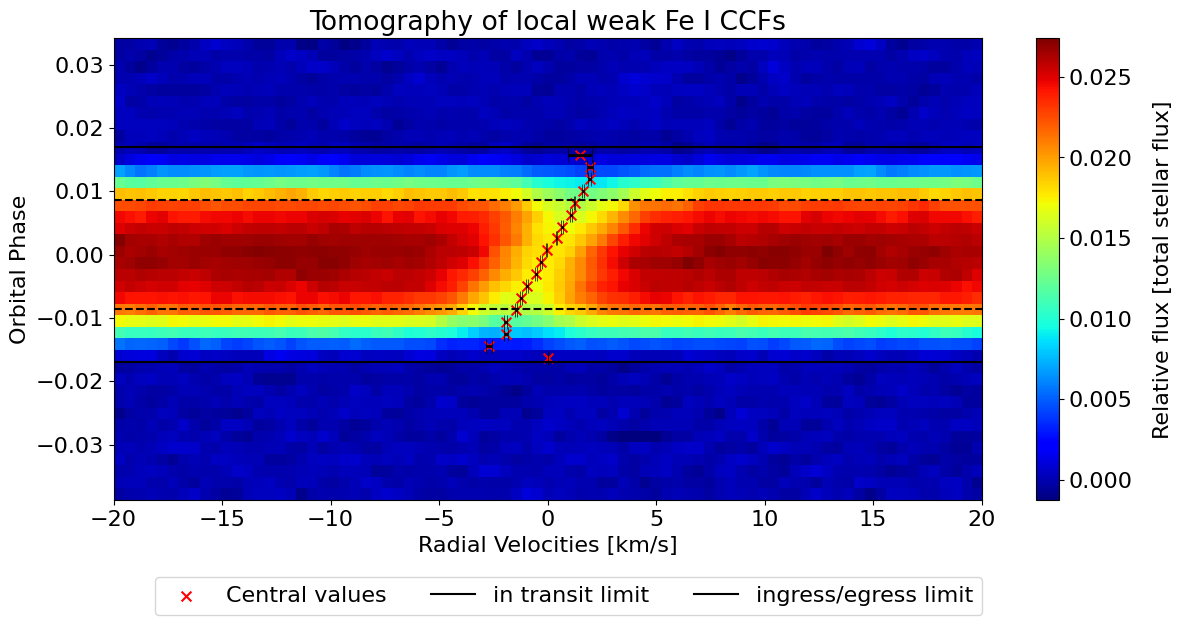

In [47]:
#tomography
X,Y = np.meshgrid(RV_target, phases)

fig,ax = plt.subplots(figsize=(14,6))

im = ax.imshow(CCFs_sub_all[:,0], cmap='jet', extent=[RV_target.min(), RV_target.max(), phases.min(), phases.max()], 
               aspect='auto', origin='lower')

l1=ax.scatter(x0_local[:,0], in_phases, marker='x', color='red', label='Central RV', s=50)
l2= ax.errorbar(x=x0_local[:,0], y=in_phases, xerr=x0_local[:,1], 
                color='black',capsize=5,capthick=0.5,linewidth=0,elinewidth=2)
l3=ax.axhline(y=-tr_dur/2, color='black')
ax.axhline(y=tr_dur/2, color='black')
l4=ax.axhline(y=-tr_ingress_egress/2, color='black',linestyle='--')
ax.axhline(y=tr_ingress_egress/2, color='black',linestyle='--')

ax.set_xlabel('Radial Velocities [km/s]')
ax.set_ylabel('Orbital Phase')
ax.set_title('Tomography of local weak Fe I CCFs')

cbar = plt.colorbar(im)
cbar.set_label('Relative flux [total stellar flux]',labelpad=15)

labels = ['Central values','in transit limit','ingress/egress limit']
fig.legend([l1,l3,l4], labels=labels, loc='lower center',ncol=5, bbox_to_anchor=(0.45, -0.1))
plt.rcParams.update({'font.size': 17})

## Parameters

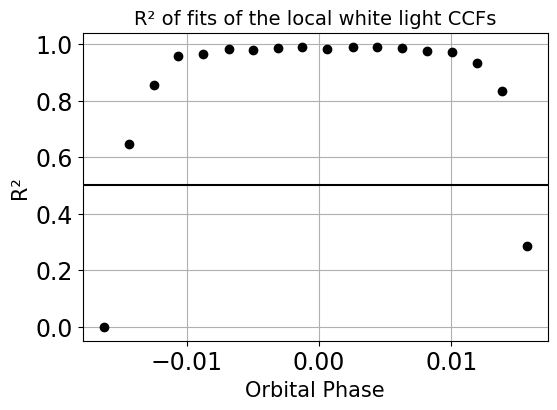

In [50]:
fig, ax = plt.subplots(figsize=(6,4))

l1=ax.scatter(in_phases, RR2, color="k")
ax.axhline(y=0.5,color='black',linestyle='-')

ax.set_title('R² of fits of the local white light CCFs',fontsize=14)
ax.set_xlabel('Orbital Phase',fontsize=15)
ax.set_ylabel('R²',fontsize=15)
ax.grid()
ax.set_axisbelow(True)

plt.show()

In [51]:
#statistical quantities
def chisquare(x,y,m,b,s):
    r = np.sum(((y-(x*m+b))/s)**2)
    rr = np.sum(((y-np.mean(y))/s)**2)
    return [r,rr]

def p_coef(x,y):
    xm = np.mean(x)
    ym = np.mean(y)
    a =np.sum((x-xm)*(y-ym))
    aa = np.sum((x-xm)**2)
    aaa = np.sum((y-ym)**2)
    p = a/np.sqrt(aa*aaa)
    return p

def spearman(x,y,y_err):
    n = 10000 
    rho_sim = np.zeros(n)
    p_sim = np.zeros(n) 

    for i in range(n):
        #Generate random weights using mean weights with measurement error
        y_sim = np.random.normal(y,y_err,len(y))
        #Calculate correlation coefficient and p-value
        rho_sim[i],p_sim[i] = spearmanr(x,y_sim)
    return rho_sim,p_sim

In [52]:
#discard points based on R² plot
inner = np.arange(2,len(mu_in)-2)

coefs_poly_rv, cov_poly_rv = np.polyfit(in_phases[inner], x0_local[:,0][inner], w=1/x0_local[:,1][inner], deg=1, cov=True)
chi_x0 = chisquare(in_phases[inner], x0_local[:,0][inner], coefs_poly_rv[0], coefs_poly_rv[1], x0_local[:,0][inner])
pearson_x0 = p_coef(in_phases[inner], x0_local[:,0][inner])
r2_x0 = r2(x0_local[:,0][inner], coefs_poly_rv[0]*in_phases[inner]+coefs_poly_rv[1])
spear_x0, spear_pval_x0 = spearman(in_phases[inner], x0_local[:,0][inner], x0_local[:,1][inner])
spearr_x0, spearr_pval_x0 = spearmanr(in_phases[inner], x0_local[:,0][inner])

print('Central RV in function of orbital phases')
print('\n fit values, m = '+str(coefs_poly_rv[0])[:6]+'±'+str(np.sqrt(cov_poly_rv[0,0]))[:6]+', b = '+str(coefs_poly_rv[1])[:6]+'±'+str(np.sqrt(cov_poly_rv[1,1]))[:6])
print('Χ² = '+str(chi_x0))
print('pearson = '+str(pearson_x0))
print('r² = '+str(r2_x0))
print('spearman = '+str(spearr_x0))
print('p-value = '+str(np.log10(spearr_pval_x0)))
print('\n')

#-------------------

coefs_poly_width, cov_poly_width = np.polyfit(mu_in[inner], width_local[:,0][inner], w=1/width_local[:,1][inner], deg=1, cov=True)
chi_width = chisquare(mu_in[inner], width_local[:,0][inner], coefs_poly_width[0], coefs_poly_width[1], width_local[:,1][inner])
pearson_width = p_coef(mu_in[inner], width_local[:,0][inner])
r2_width = r2(width_local[:,0][inner], coefs_poly_width[0]*mu_in[inner]+coefs_poly_width[1])
spear_width, spear_pval_width = spearman(mu_in[inner], width_local[:,0][inner], width_local[:,1][inner])
spearr_width, spearr_pval_width = spearmanr(mu_in[inner], width_local[:,0][inner])

print('Line-width measure in function of mu')
print('\nfit values, m = '+str(coefs_poly_width[0])[:5]+'±'+str(np.sqrt(cov_poly_width[0,0]))[:5]+', b = '+str(coefs_poly_width[1])[:5]+'±'+str(np.sqrt(cov_poly_width[1,1]))[:5])
print('Χ² = '+str(chi_width))
print('pearson = '+str(pearson_width))
print('r² = '+str(r2_width))
print('spearman = '+str(spearr_width))
print('p-value = '+str(np.log10(spearr_pval_width)))
print('\n')

#-------------------

coefs_poly_depth, cov_poly_width = np.polyfit(mu_in[inner], depth_local[:,0][inner], w=1/depth_local[:,1][inner], deg=1, cov=True)
chi_depth = chisquare(mu_in[inner], depth_local[:,0][inner], coefs_poly_depth[0], coefs_poly_depth[1], depth_local[:,1][inner])
pearson_depth = p_coef(mu_in[inner], depth_local[:,0][inner])
r2_depth = r2(depth_local[:,0][inner], coefs_poly_depth[0]*mu_in[inner]+coefs_poly_depth[1])
spear_depth, spear_pval_depth = spearman(mu_in[inner], depth_local[:,0][inner], depth_local[:,1][inner])
spearr_depth, spearr_pval_depth = spearmanr(mu_in[inner], depth_local[:,0][inner])

print('Line-center intensity in function of mu')
print('\n fit values, m = '+str(coefs_poly_depth[0])[:5]+'±'+str(np.sqrt(cov_poly_width[0,0]))[:5]+', b = '+str(coefs_poly_depth[1])[:5]+'±'+str(np.sqrt(cov_poly_width[1,1]))[:5])
print('Χ² = '+str(chi_depth))
print('pearson = '+str(pearson_depth))
print('r² = '+str(r2_depth))
print('spearman = '+str(spearr_depth))
print('p-value = '+str(np.log10(spearr_pval_depth)))

Central RV in function of orbital phases

 fit values, m = 167.06±3.0911, b = -0.061±0.0178
Χ² = [3.993275575044822, 14.029763125958597]
pearson = 0.9979378079780666
r² = 0.9954920427353707
spearman = 0.9956043956043955
p-value = -12.98649063008978


Line-width measure in function of mu

fit values, m = -0.52±0.231, b = 2.354±0.149
Χ² = [17.55789415547225, 27.90283062101801]
pearson = -0.6102893252870999
r² = 0.3718744263031182
spearman = -0.5912087912087912
p-value = -1.585514443655069


Line-center intensity in function of mu

 fit values, m = -10.0±2.152, b = 72.94±1.373
Χ² = [15.256741654693174, 51.66315552753623]
pearson = -0.8497115563926675
r² = 0.7218271017709981
spearman = -0.7714285714285714
p-value = -2.9091576526340037


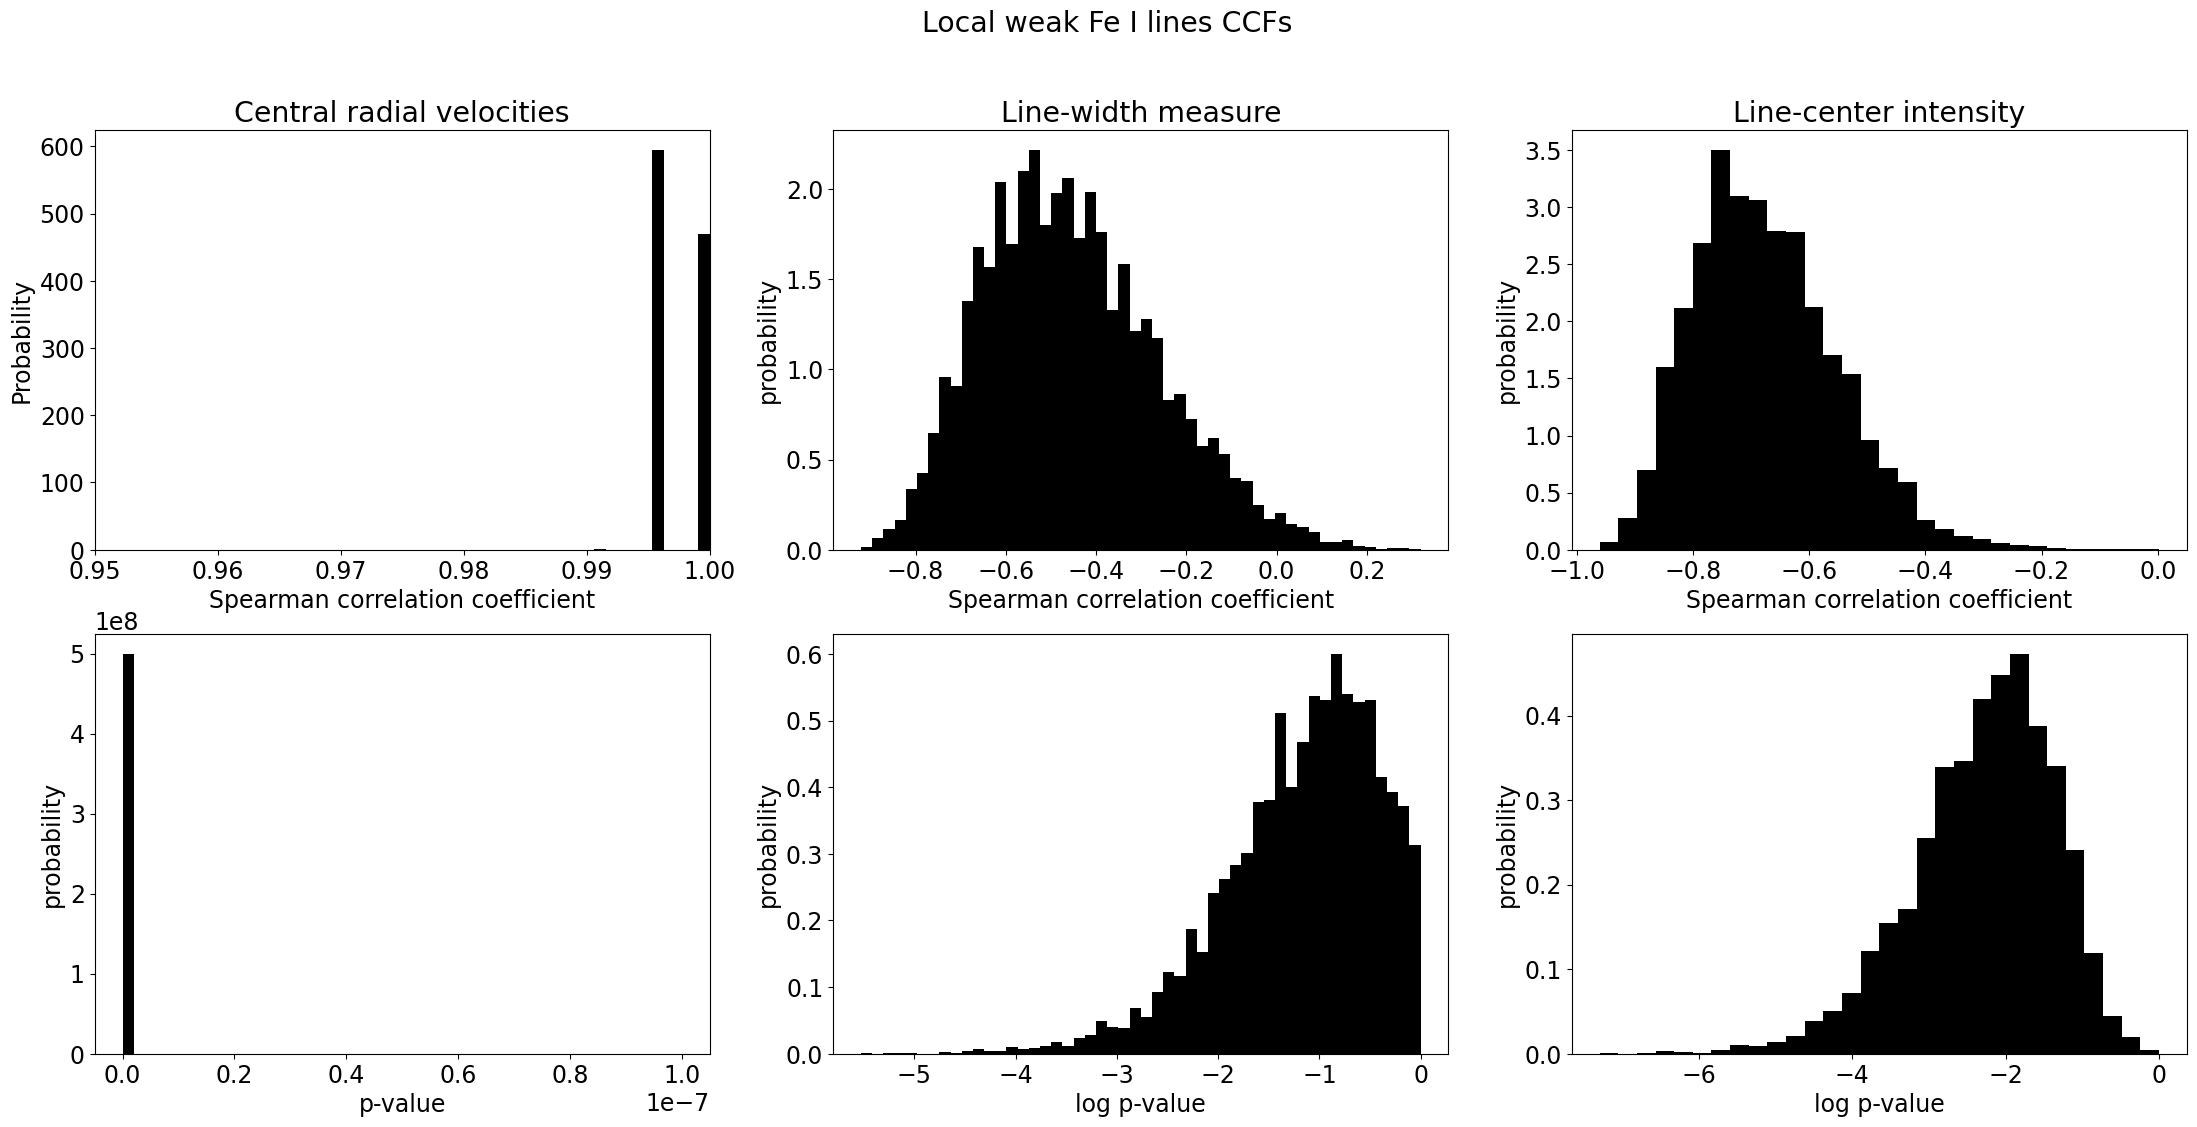

In [54]:
#spearman and p-value distributions
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(27,12))

axes[0,0].hist(np.concatenate((spear_x0[2:], spear_x0[:2]-0.005)), density=True, color='black', bins=10)
axes[0,0].set_title('Central radial velocities')
axes[0,0].set_xlabel('Spearman correlation coefficient')
axes[0,0].set_ylabel('Probability')
axes[0,0].set_xlim((0.95,1))

axes[1,0].hist(np.concatenate((spear_pval_x0[2:], spear_pval_x0[:2]+0.0000001)), density=True, color='black', bins=50)
axes[1,0].set_xlabel('p-value')
axes[1,0].set_ylabel('probability')


axes[0,1].hist(spear_width, density=True, color='black', bins=50)
axes[0,1].set_title('Line-width measure')
axes[0,1].set_xlabel('Spearman correlation coefficient')
axes[0,1].set_ylabel('probability')

axes[1,1].hist(np.log10(spear_pval_width), density=True,color='black',bins=50)
axes[1,1].set_xlabel('log p-value')
axes[1,1].set_ylabel('probability')


axes[0,2].hist(spear_depth,density=True,color='black',bins=30)
axes[0,2].set_title('Line-center intensity')
axes[0,2].set_xlabel('Spearman correlation coefficient')
axes[0,2].set_ylabel('probability')

axes[1,2].hist(np.log10(spear_pval_depth),density=True,color='black',label='day 11 values',bins=30)
axes[1,2].set_xlabel('log p-value')
axes[1,2].set_ylabel('probability')

plt.suptitle('Local weak Fe I lines CCFs')
plt.show()

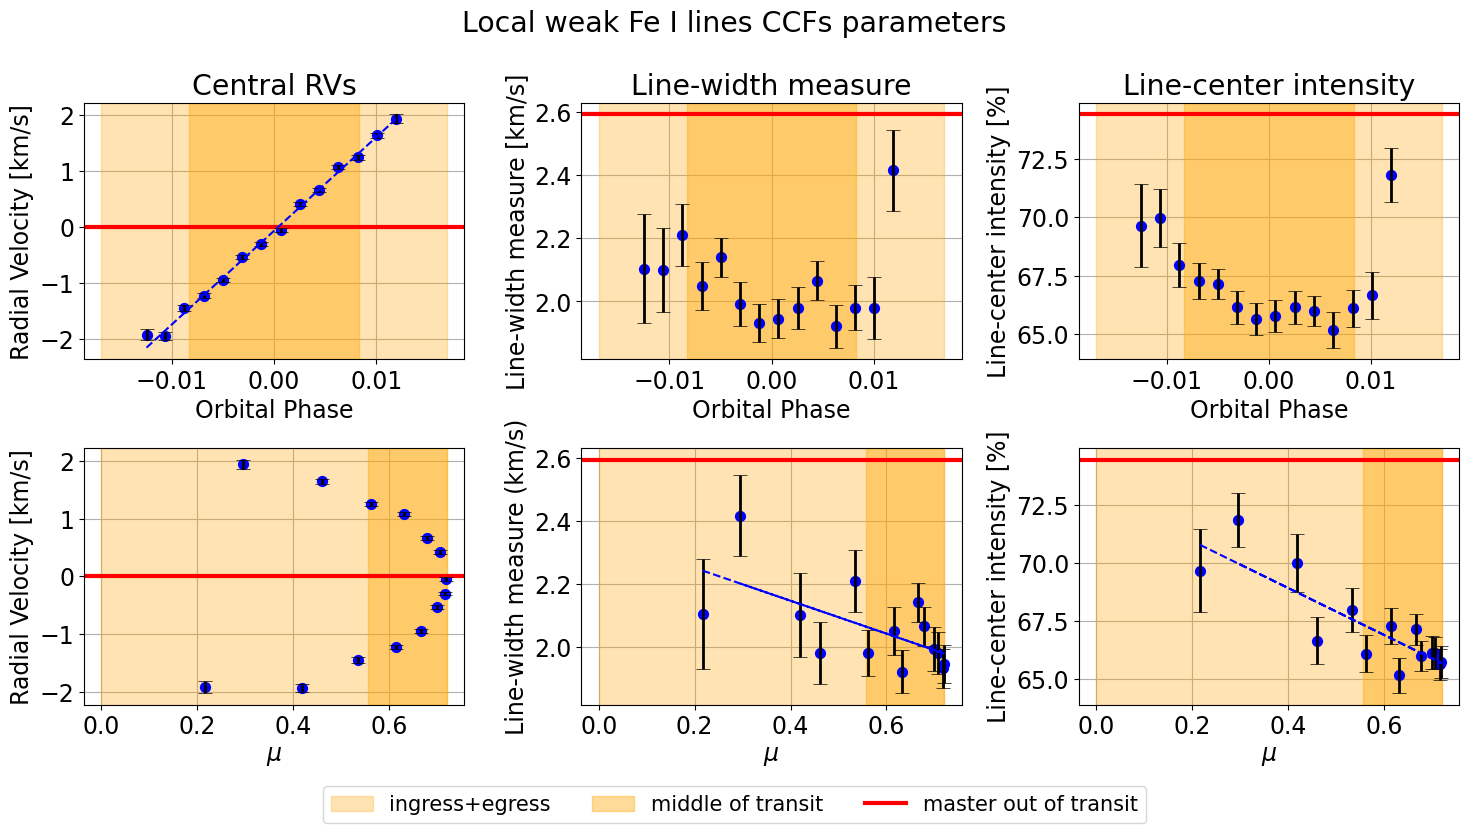

In [55]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,8))

axes[0,0].axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange')
axes[0,0].axvspan(tr_ingress_egress/2.-tr_dur/2, tr_dur/2-tr_ingress_egress/2., alpha=0.4, color='orange')
axes[0,0].axhline(y=master_x0, color='red', linestyle='-', lw=3,)
axes[0,0].scatter(in_phases[inner], x0_local[:,0][inner],color='blue',s=50)
axes[0,0].errorbar(x=in_phases[inner], y=x0_local[:,0][inner], yerr=x0_local[:,1][inner], capsize=5, capthick=0.5, color='black', linewidth=0, elinewidth=2)
axes[0,0].plot(in_phases[inner], coefs_poly_rv[0]*in_phases[inner]+coefs_poly_rv[1], color='blue', linestyle='--')
axes[0,0].set_title('Central RVs')
axes[0,0].set_xlabel('Orbital Phase')
axes[0,0].set_ylabel('Radial Velocity [km/s]')
axes[0,0].grid()
axes[0,0].set_axisbelow(True)

axes[1,0].axvspan(0, mu_max, alpha=0.3, color='orange')
axes[1,0].axvspan(mu_min, mu_max, alpha=0.4, color='orange')
axes[1,0].axhline(y=master_x0, color='red', linestyle='-', lw=3)
axes[1,0].scatter(mu_in[inner], x0_local[:,0][inner], color='blue', s=50)
axes[1,0].errorbar(x=mu_in[inner], y=x0_local[:,0][inner], yerr=x0_local[:,1][inner], capsize=5, capthick=0.5, color='black', linewidth=0, elinewidth=2)
axes[1,0].set_xlabel(r'$\mu$')
axes[1,0].set_ylabel('Radial Velocity [km/s]')
axes[1,0].grid()
axes[1,0].set_axisbelow(True)


axes[0,1].axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange')
axes[0,1].axvspan(tr_ingress_egress/2.-tr_dur/2, tr_dur/2-tr_ingress_egress/2., alpha=0.4, color='orange')
axes[0,1].axhline(y=master_width, color='red', linestyle='-', lw=3)
axes[0,1].scatter(in_phases[inner], width_local[:,0][inner],color='blue',s=50)
axes[0,1].errorbar(x=in_phases[inner], y=width_local[:,0][inner], yerr=width_local[:,1][inner],capsize=5,capthick=0.5,color='black',linewidth=0,elinewidth=2)
axes[0,1].set_xlabel('Orbital Phase')
axes[0,1].set_ylabel('Line-width measure [km/s]')
axes[0,1].set_title('Line-width measure')
axes[0,1].grid()
axes[0,1].set_axisbelow(True)

axes[1,1].axvspan(0, mu_max, alpha=0.3, color='orange')
axes[1,1].axvspan(mu_min, mu_max, alpha=0.4, color='orange')
axes[1,1].axhline(y=master_width, color='red', linestyle='-', lw=3)
axes[1,1].scatter(mu_in[inner], width_local[:,0][inner],color='blue',s=50)
axes[1,1].errorbar(x=mu_in[inner], y=width_local[:,0][inner], yerr=width_local[:,1][inner], capsize=5,capthick=0.5,color='black',linewidth=0,elinewidth=2)
axes[1,1].plot(mu_in[inner], coefs_poly_width[0]*mu_in[inner]+coefs_poly_width[1], color='blue', linestyle='--')
axes[1,1].set_xlabel(r'$\mu$')
axes[1,1].set_ylabel('Line-width measure (km/s)')
axes[1,1].grid()
axes[1,1].set_axisbelow(True)


axes[0,2].axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange')
axes[0,2].axvspan(tr_ingress_egress/2.-tr_dur/2, tr_dur/2-tr_ingress_egress/2., alpha=0.4, color='orange')
axes[0,2].axhline(y=master_depth, color='red', linestyle='-', lw=3)
axes[0,2].scatter(in_phases[inner], depth_local[:,0][inner],color='blue',s=50)
axes[0,2].errorbar(x=in_phases[inner], y=depth_local[:,0][inner], yerr=depth_local[:,1][inner],capsize=5,capthick=0.5,color='black',linewidth=0,elinewidth=2)
axes[0,2].set_xlabel('Orbital Phase')
axes[0,2].set_ylabel('Line-center intensity [%]')
axes[0,2].set_title('Line-center intensity')
axes[0,2].grid()
axes[0,2].set_axisbelow(True)

l0=axes[1,2].axvspan(0, mu_max, alpha=0.3, color='orange')
l1=axes[1,2].axvspan(mu_min, mu_max, alpha=0.4, color='orange')
l2=axes[1,2].axhline(y=master_depth, color='red', linestyle='-', lw=3)
axes[1,2].scatter(mu_in[inner], depth_local[:,0][inner], color='blue', s=50)
axes[1,2].errorbar(x=mu_in[inner],y=depth_local[:,0][inner], yerr=depth_local[:,1][inner],capsize=5,capthick=0.5,color='black',linewidth=0,elinewidth=2)
axes[1,2].plot(mu_in[inner], coefs_poly_depth[0]*mu_in[inner]+coefs_poly_depth[1], color='blue', linestyle='--')
axes[1,2].set_xlabel(r'$\mu$')
axes[1,2].set_ylabel('Line-center intensity [%]')
axes[1,2].grid()
axes[1,2].set_axisbelow(True)


plt.suptitle('Local weak Fe I lines CCFs parameters')

labels = ['ingress+egress','middle of transit','master out of transit']
fig.legend([l0,l1,l2], labels=labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.05), fontsize=15)
plt.tight_layout()
plt.show()

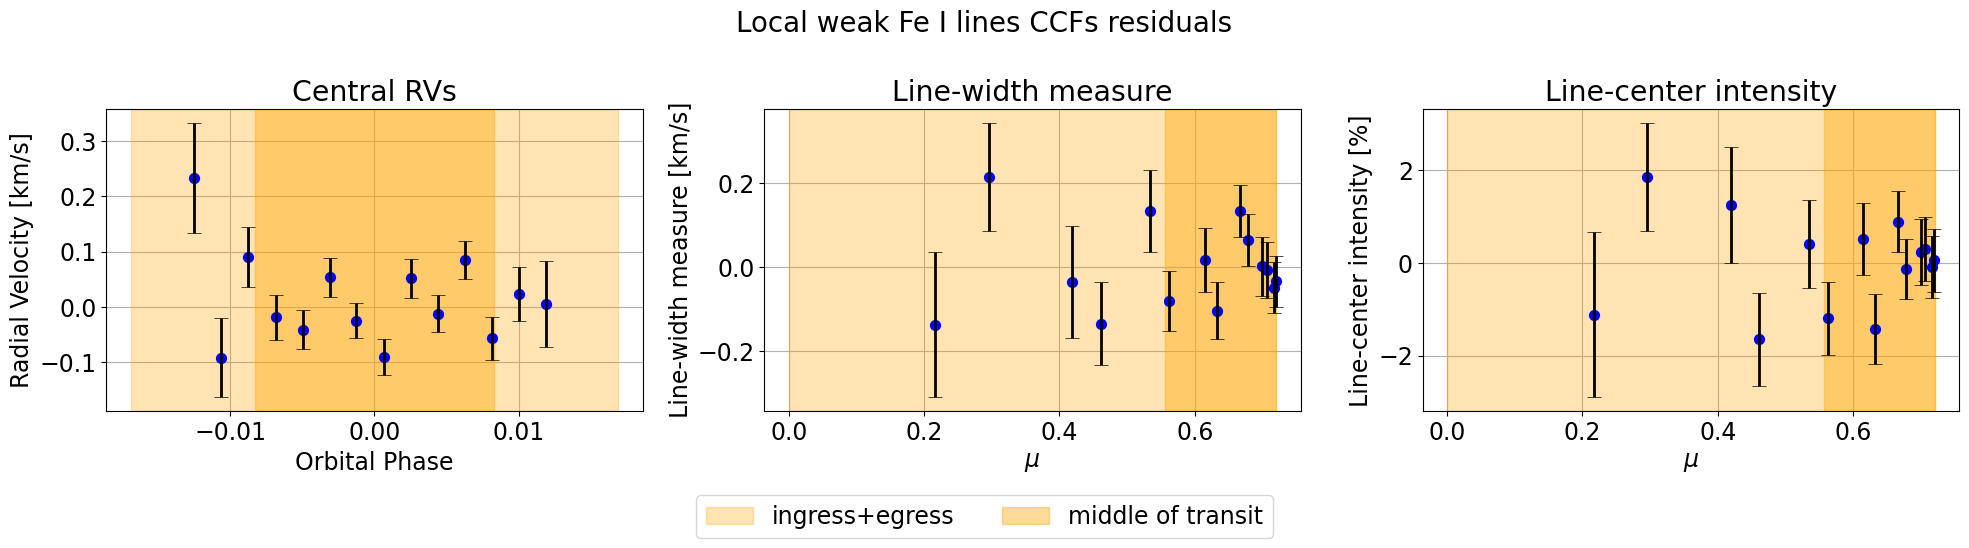

In [56]:
fig, axes = plt.subplots(ncols=3, figsize=(20,5))

axes[0].axvspan(-tr_dur/2., tr_dur/2., alpha=0.3, color='orange')
axes[0].axvspan(tr_ingress_egress/2.-tr_dur/2, tr_dur/2-tr_ingress_egress/2., alpha=0.4, color='orange')
axes[0].scatter(in_phases[inner], x0_local[:,0][inner]-(coefs_poly_rv[0]*in_phases[inner]+coefs_poly_rv[1]), color='blue', s=50)
axes[0].errorbar(x=in_phases[inner],y=x0_local[:,0][inner]-(coefs_poly_rv[0]*in_phases[inner]+coefs_poly_rv[1]), yerr=x0_local[:,1][inner], capsize=5, capthick=0.5, color='black', linewidth=0, elinewidth=2)
axes[0].set_title('Central RVs')
axes[0].set_xlabel('Orbital Phase')
axes[0].set_ylabel('Radial Velocity [km/s]')
axes[0].grid()
axes[0].set_axisbelow(True)

axes[1].axvspan(0, mu_max, alpha=0.3, color='orange')
axes[1].axvspan(mu_min, mu_max, alpha=0.4, color='orange')
axes[1].scatter(mu_in[inner], width_local[:,0][inner]-(coefs_poly_width[0]*mu_in[inner]+coefs_poly_width[1]), color='blue', s=50)
axes[1].errorbar(x=mu_in[inner], y=width_local[:,0][inner]-(coefs_poly_width[0]*mu_in[inner]+coefs_poly_width[1]), yerr=width_local[:,1][inner], capsize=5, capthick=0.5, color='black', linewidth=0, elinewidth=2)
axes[1].set_title('Line-width measure')
axes[1].set_xlabel(r'$\mu$')
axes[1].set_ylabel('Line-width measure [km/s]')
axes[1].grid()
axes[1].set_axisbelow(True)

l0=axes[2].axvspan(0, mu_max, alpha=0.3, color='orange')
l1=axes[2].axvspan(mu_min, mu_max, alpha=0.4, color='orange')
axes[2].scatter(mu_in[inner], depth_local[:,0][inner]-(coefs_poly_depth[0]*mu_in[inner]+coefs_poly_depth[1]), color='blue', s=50)
axes[2].errorbar(x=mu_in[inner], y=depth_local[:,0][inner]-(coefs_poly_depth[0]*mu_in[inner]+coefs_poly_depth[1]), yerr=depth_local[:,1][inner], capsize=5, capthick=0.5, color='black', linewidth=0, elinewidth=2)
axes[2].set_title('Line-center intensity')
axes[2].set_xlabel(r'$\mu$')
axes[2].set_ylabel('Line-center intensity [%]')
axes[2].grid()
axes[2].set_axisbelow(True)

plt.suptitle('Local weak Fe I lines CCFs residuals', fontsize=20)

labels = ['ingress+egress','middle of transit']
fig.legend([l0,l1], labels=labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()